<a href="https://colab.research.google.com/github/BogdanT54/Economic-Cycles-and-Market-Returns/blob/main/Financial_Assets_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install yfinance statsmodels arch seaborn rpy2

In [ ]:
# Importuri
from datetime import timedelta
import yfinance as yf
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
import statsmodels.tsa.stattools as ts
from google.colab import files
from arch.unitroot import ADF, PhillipsPerron, KPSS
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.dates as mdates
import warnings
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import kurtosis, skew
import numpy as np
import pandas as pd
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings('ignore')

# **Citire, prelucrare si curatare date**

In [ ]:
#Fac un dataframe cu fisierul dat
sp500 = yf.download('^GSPC', start='2005-01-01', end='2025-12-30', interval='1d')
gold = yf.download('GC=F', start='2005-01-01', end='2025-12-30', interval='1d')
oil = yf.download('CL=F', start='2005-01-01', end='2025-12-30', interval='1d')

bitcoin = pd.read_csv ('Bitcoin.csv', index_col=0, parse_dates=True)


#Citire, curatare si prelucrare date ROTX
rotx = pd.read_csv('ROTX.csv',index_col=0, parse_dates=True)

#Verific Df-ul
rotx.head(-1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2005-03-14,12157.76,12215.43,11994.94,12060.73
2005-03-15,11998.46,12005.45,11707.92,11778.07
2005-03-16,11715.80,11766.15,11477.37,11477.37
2005-03-17,11446.23,11446.23,10672.62,10672.62
2005-03-18,10610.35,10610.35,9617.39,10367.18
...,...,...,...,...
2025-05-30,40155.19,40856.26,40154.98,40856.26
2025-06-02,40859.24,41402.59,40634.12,41364.90
2025-06-03,41364.34,41568.92,40805.11,41232.44


In [ ]:
# Extragere coloana 'Close' și redenumire
sp500_close = sp500['Close']
gold_close = gold['Close']
oil_close = oil['Close']
bitcoin_close = bitcoin['Close']
rotx_close = rotx['Close']

# Concatenare
real_prices_df = pd.concat([sp500_close, gold_close, oil_close, bitcoin_close, rotx_close], axis=1)
real_prices_df.columns = ['SP500', 'Gold', 'Oil', 'Bitcoin', 'ROTX']

# Vizualizare
real_prices_df.head()

,SP500,Gold,Oil,Bitcoin,ROTX
Date,,,,,
2005-01-03,1202.079956,428.700012,42.119999,NaN,NaN
2005-01-04,1188.050049,428.500000,43.910000,NaN,NaN
2005-01-05,1183.739990,426.600006,43.389999,NaN,NaN
2005-01-06,1187.890015,421.000000,45.560001,NaN,NaN
2005-01-07,1186.189941,418.899994,45.430000,NaN,NaN


In [ ]:
# Prelucrare randamente + logaritmare cu backfill
sp500_log_returns = np.log(sp500 / sp500.shift(1)).replace([np.inf, -np.inf, 0], np.nan).dropna().bfill()
gold_log_returns = np.log(gold / gold.shift(1)).replace([np.inf, -np.inf, 0], np.nan).dropna().bfill()
oil_log_returns = np.log(oil / oil.shift(1)).replace([np.inf, -np.inf, 0], np.nan).dropna().bfill()
bitcoin_log_returns = np.log(bitcoin / bitcoin.shift(1)).bfill()
rotx_log_returns = np.log(rotx / rotx.shift(1)).replace([np.inf, -np.inf, 0], np.nan).dropna().bfill()


sp500_log_returns_close = sp500_log_returns['Close']
gold_log_returns_close = gold_log_returns['Close']
oil_log_returns_close = oil_log_returns['Close']
bitcoin_log_returns_close = bitcoin_log_returns['Close']
rotx_log_returns_close = rotx_log_returns['Close']

log_real_prices_df = pd.concat([sp500_log_returns_close, gold_log_returns_close, oil_log_returns_close, bitcoin_log_returns_close, rotx_log_returns_close], axis=1)
log_real_prices_df.columns = ['SP500', 'Gold', 'Oil', 'Bitcoin', 'ROTX']

log_real_prices_df.head(-10)

,SP500,Gold,Oil,Bitcoin,ROTX
Date,,,,,
2005-01-04,-0.011740,-0.000467,0.041619,NaN,NaN
2005-01-05,-0.003634,-0.004444,-0.011913,NaN,NaN
2005-01-06,0.003500,-0.013214,0.048801,NaN,NaN
2005-01-07,-0.001432,NaN,-0.002857,NaN,NaN
2005-01-10,0.003417,NaN,-0.002204,NaN,NaN
...,...,...,...,...,...
2025-05-26,NaN,NaN,NaN,NaN,0.014378
2025-05-27,0.020253,-0.019362,-0.010456,NaN,0.005236
2025-05-28,-0.005587,-0.001669,0.015481,NaN,0.005537


In [ ]:
statistics = real_prices_df.describe()

# adaugam explicit linia 'median'
statistics.loc['median'] = real_prices_df.median()

# ordonam liniile ca sa apara median dupa mean
statistics = statistics.reindex(['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max'])

statistics.head(20)

,SP500,Gold,Oil,Bitcoin,ROTX
count,5145.000000,5139.000000,5143.000000,5430.000000,5047.000000
mean,2428.842044,1376.517065,71.769010,16343.879548,17531.368474
median,2016.709961,1300.699951,70.500000,4093.017227,15909.560000
std,1359.109960,537.794640,21.234703,24523.932324,8181.446556
min,676.530029,412.600006,-37.630001,0.056402,3440.980000
25%,1316.630005,1093.000000,55.720001,241.913502,11797.705000
50%,2016.709961,1300.699951,70.500000,4093.017227,15909.560000
75%,3191.139893,1729.250000,87.400002,24316.460773,20707.915000
max,6144.149902,3452.600098,145.289993,111673.284000,41843.420000


In [ ]:
statistics = log_real_prices_df.describe()

# adaugam explicit linia 'median'
statistics.loc['median'] = log_real_prices_df.median()

# ordonam liniile ca sa apara median dupa mean
statistics = statistics.reindex(['count', 'mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max'])

statistics.head(20)

,SP500,Gold,Oil,Bitcoin,ROTX
count,5109.000000,4700.000000,5053.000000,5430.000000,5008.000000
mean,0.000321,0.000382,0.000152,0.002672,0.000231
median,0.000733,0.000513,0.001113,0.001916,0.000764
std,0.012222,0.011303,0.025900,0.048348,0.014595
min,-0.127652,-0.098206,-0.282206,-0.675195,-0.196532
25%,-0.004103,-0.004967,-0.012534,-0.012682,-0.005275
50%,0.000733,0.000513,0.001113,0.001916,0.000764
75%,0.005731,0.006306,0.013092,0.018720,0.006439
max,0.109572,0.086432,0.223940,0.395243,0.104292


# **Analiza Descriptiva**

# **Multiple**

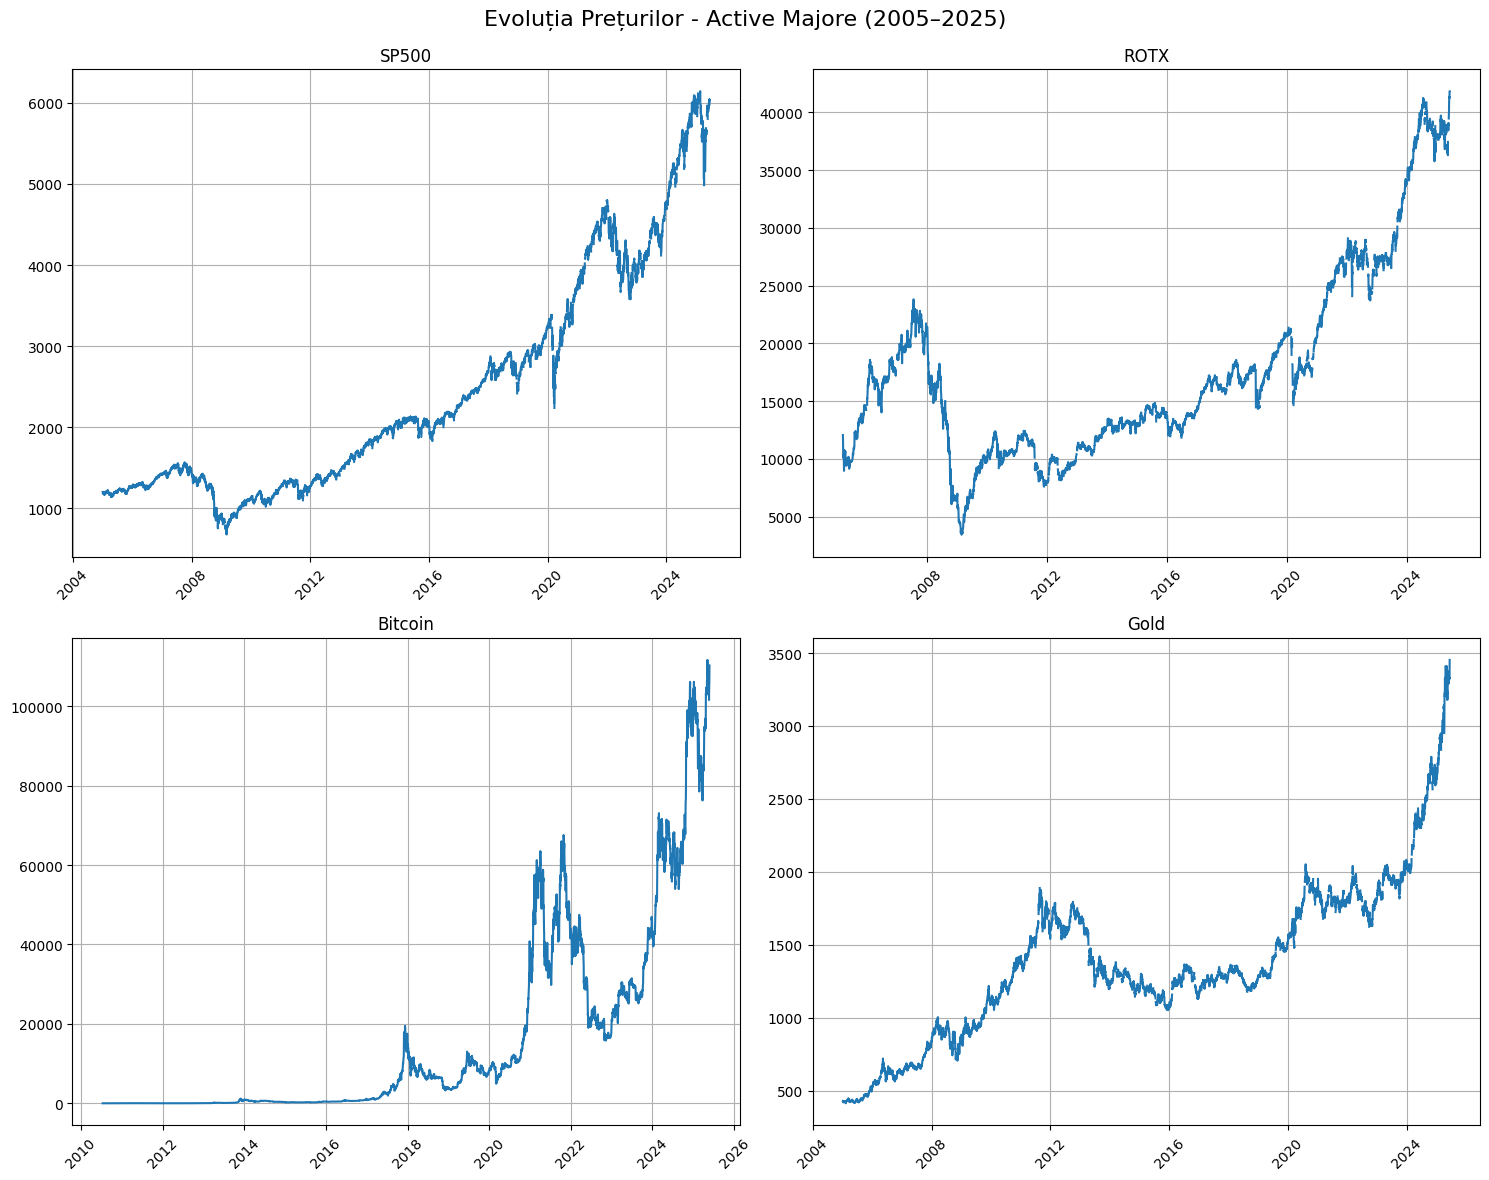

In [ ]:
import matplotlib.pyplot as plt

# Creez figura cu 3 rânduri și 2 coloane (ultimul subplot va rămâne gol)
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Evoluția Prețurilor - Active Majore (2005–2025)', fontsize=16)

# Așezăm activele în ordinea dorită: SP500, Gold, Bitcoin, ROTX, Oil
assets = ['SP500', 'ROTX', 'Bitcoin', 'Gold',]

# Flatten pentru accesare simplificată
axs = axs.flatten()

# Plot individual
for i, asset in enumerate(assets):
    axs[i].plot(real_prices_df.index, real_prices_df[asset])
    axs[i].set_title(asset)
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

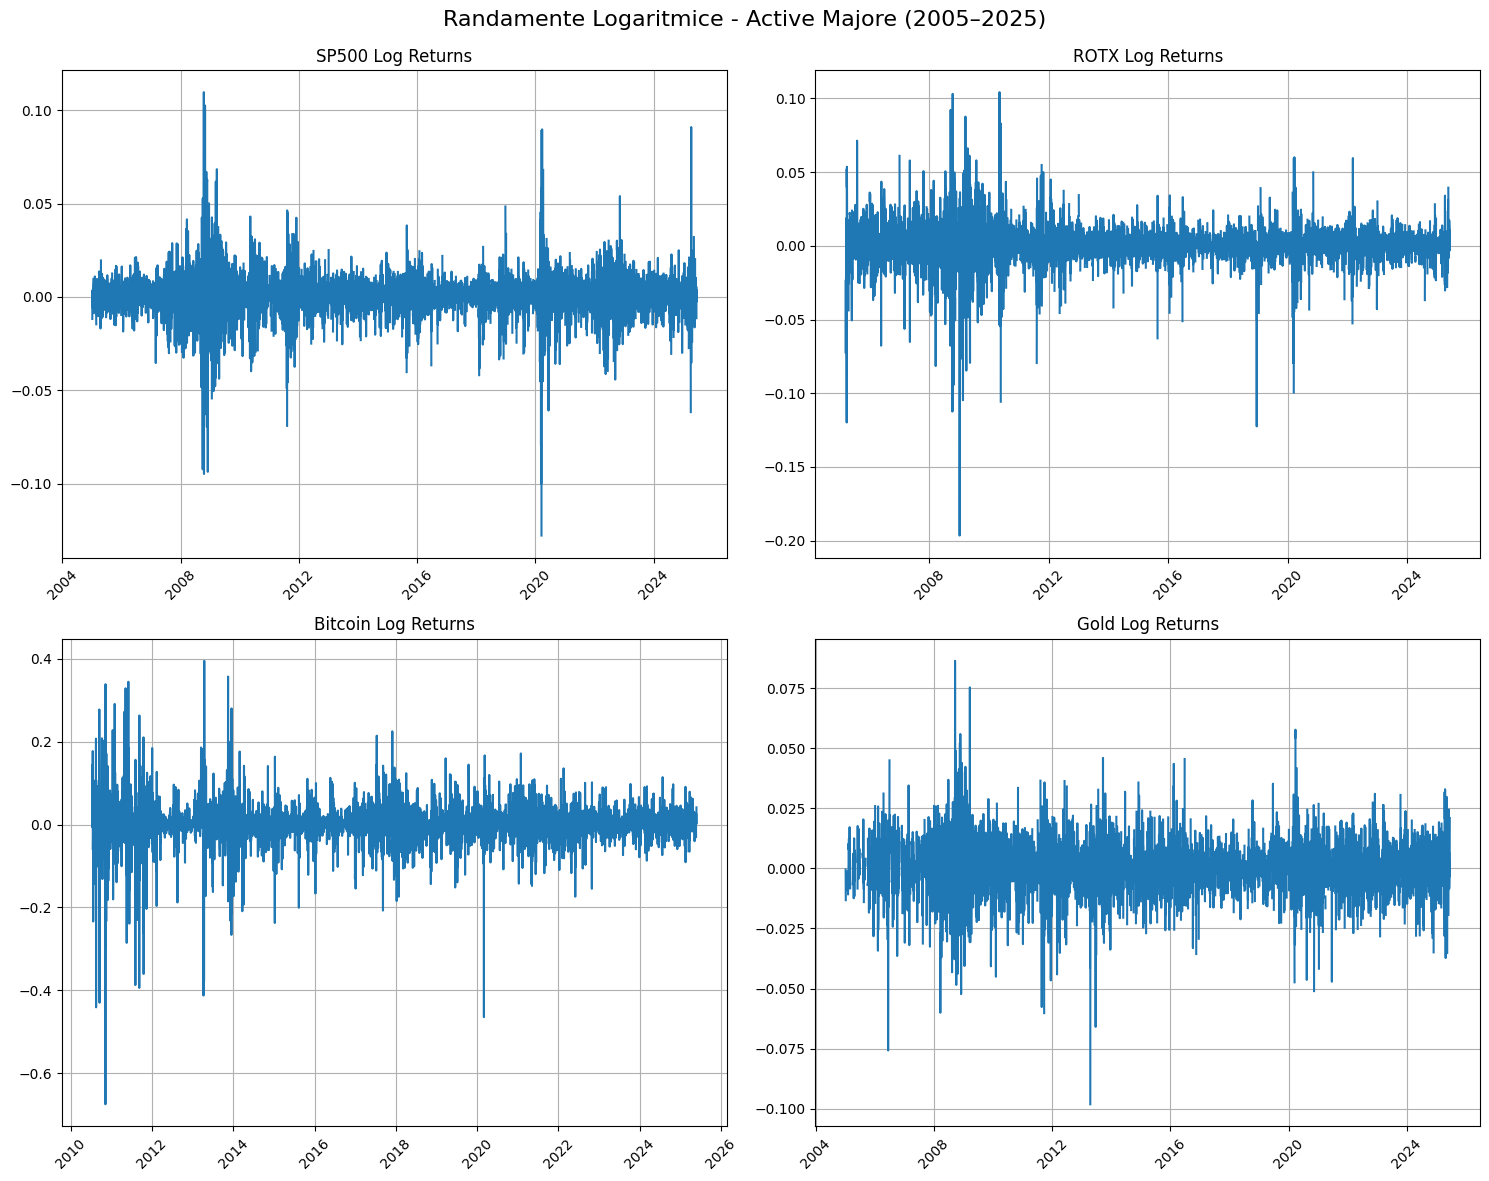

In [ ]:
import matplotlib.pyplot as plt

# Creez figura cu 2 rânduri și 2 coloane
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Randamente Logaritmice - Active Majore (2005–2025)', fontsize=16)

# Aleg activele (fără Oil)
assets = ['SP500', 'ROTX', 'Bitcoin', 'Gold']

# Flatten pentru acces simplu
axs = axs.flatten()

# Plot individual
for i, asset in enumerate(assets):
    axs[i].plot(log_real_prices_df.index, log_real_prices_df[asset])
    axs[i].set_title(f"{asset} Log Returns")
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


# **Individuale**

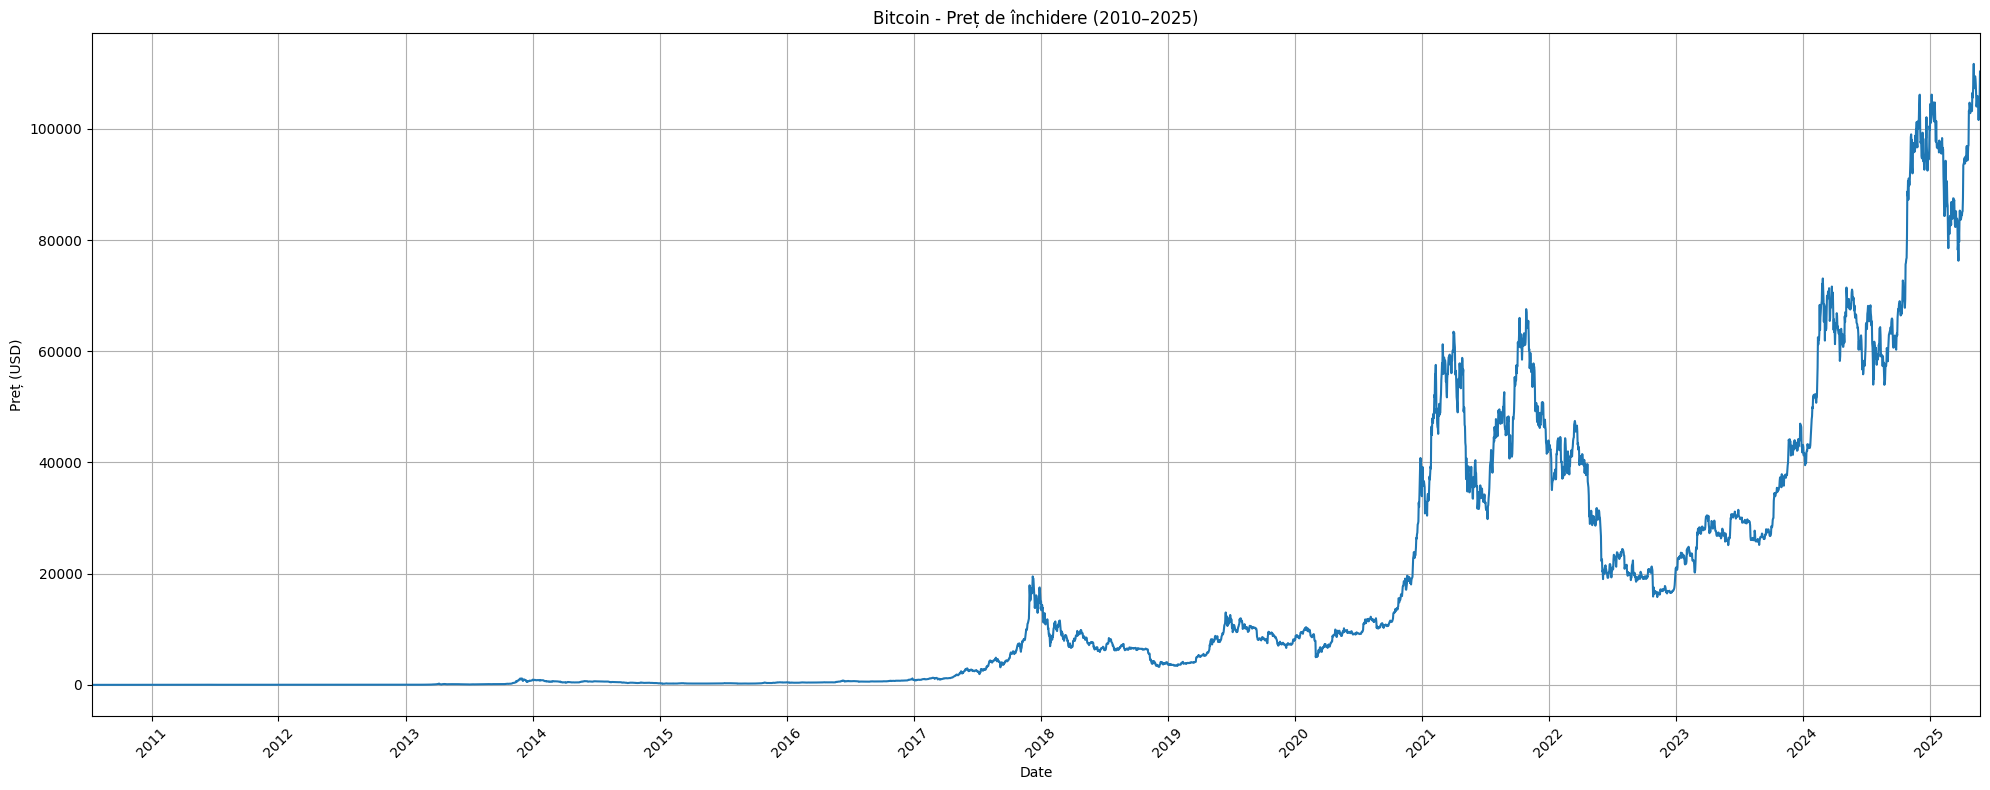

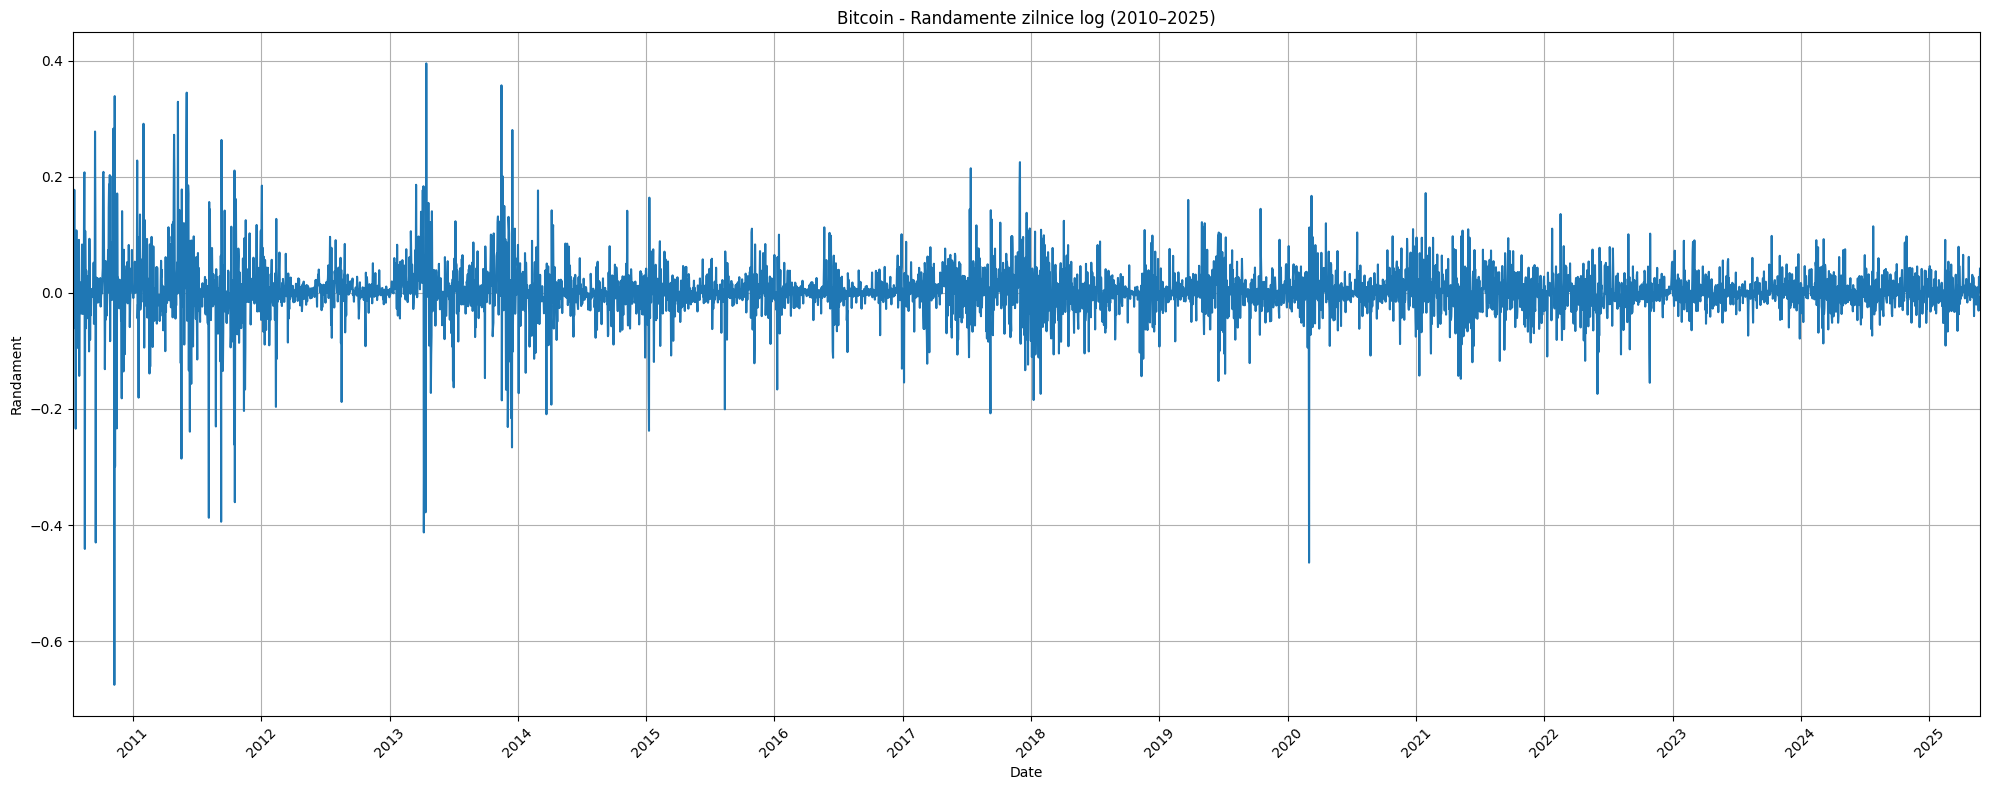

In [ ]:
#Bitcoin pret inchidere plot
fig, ax = plt.subplots(figsize=(20, 8))
bitcoin['Close'].plot(ax=ax, title='Bitcoin - Preț de închidere (2010–2025)', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()


#Bitcoin log randamente
fig, ax = plt.subplots(figsize=(20, 8))
bitcoin_log_returns['Close'].plot(ax=ax, title='Bitcoin - Randamente zilnice log (2010–2025)', legend=False)
ax.set_ylabel("Randament")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

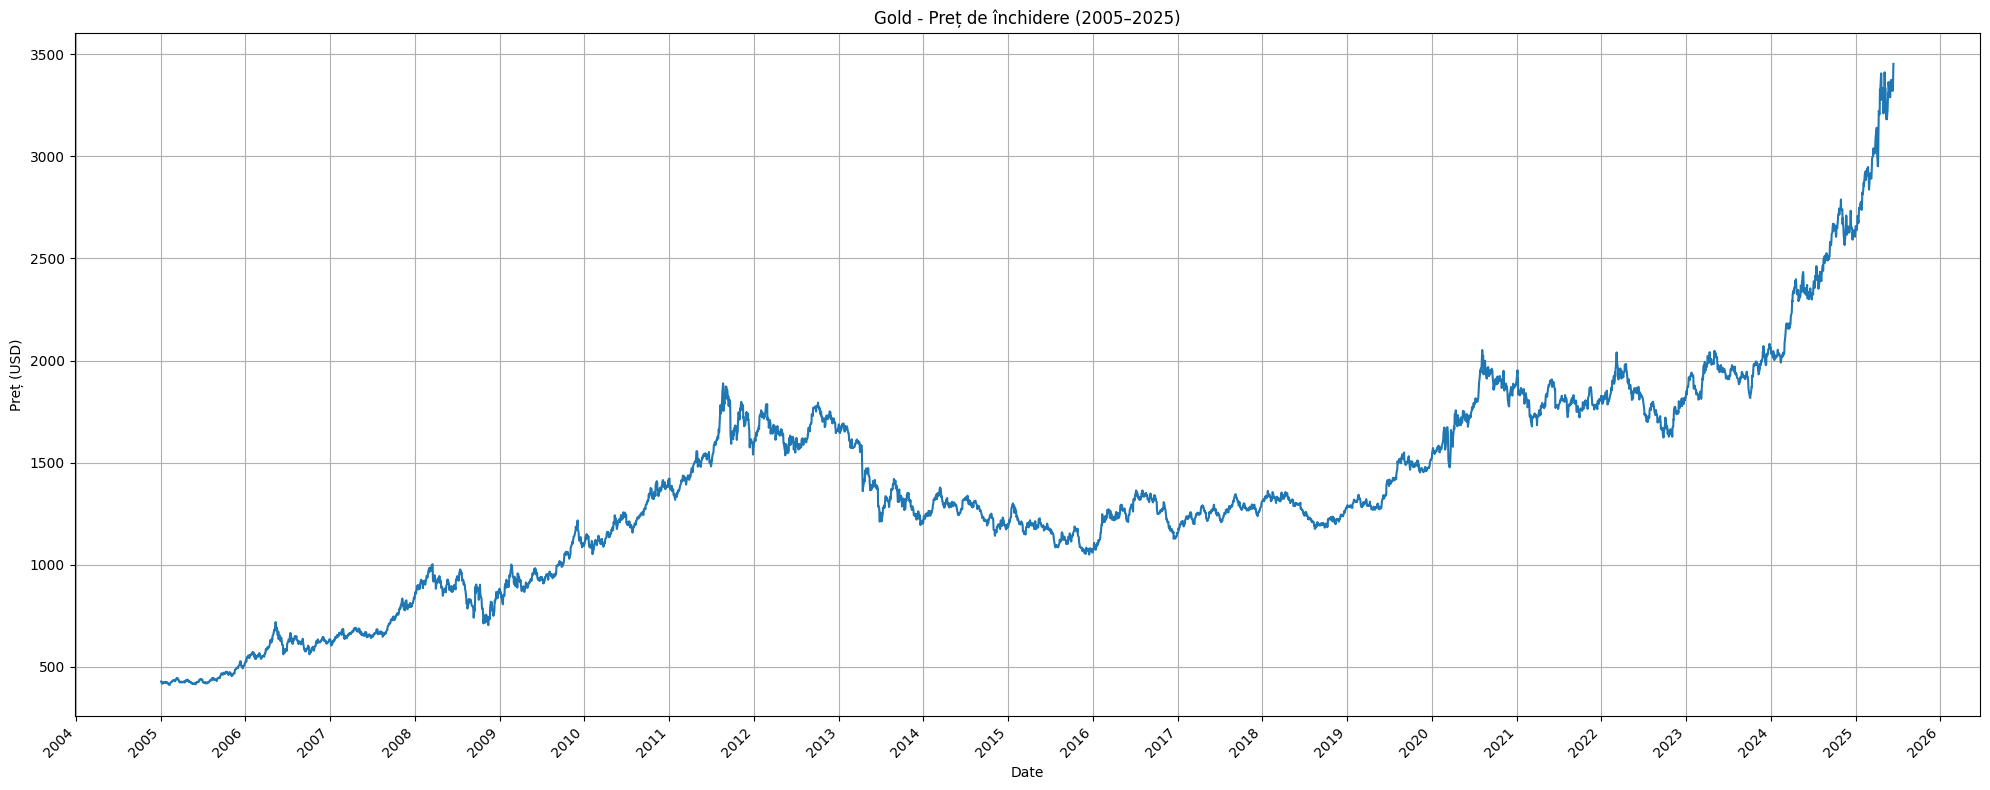

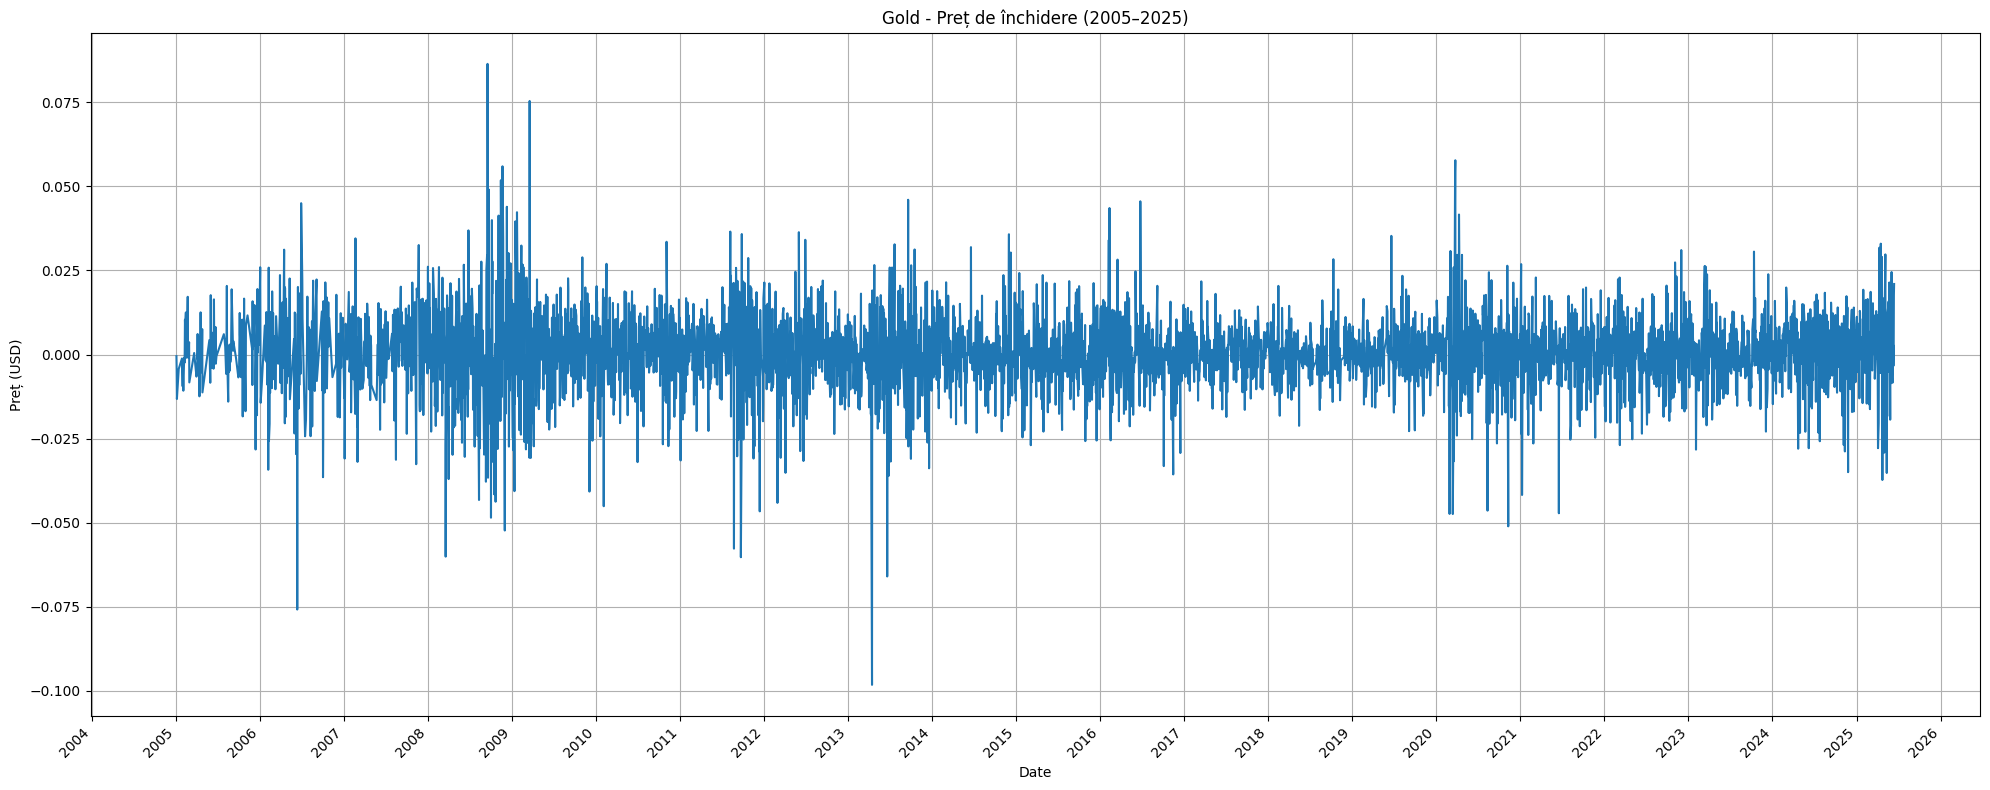

In [ ]:
#Gold plot
fig, ax = plt.subplots(figsize=(20, 8))
gold['Close'].plot(ax=ax, title='Gold - Preț de închidere (2005–2025)', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(20, 8))
gold_log_returns['Close'].plot(ax=ax, title='Gold - Preț de închidere (2005–2025)', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

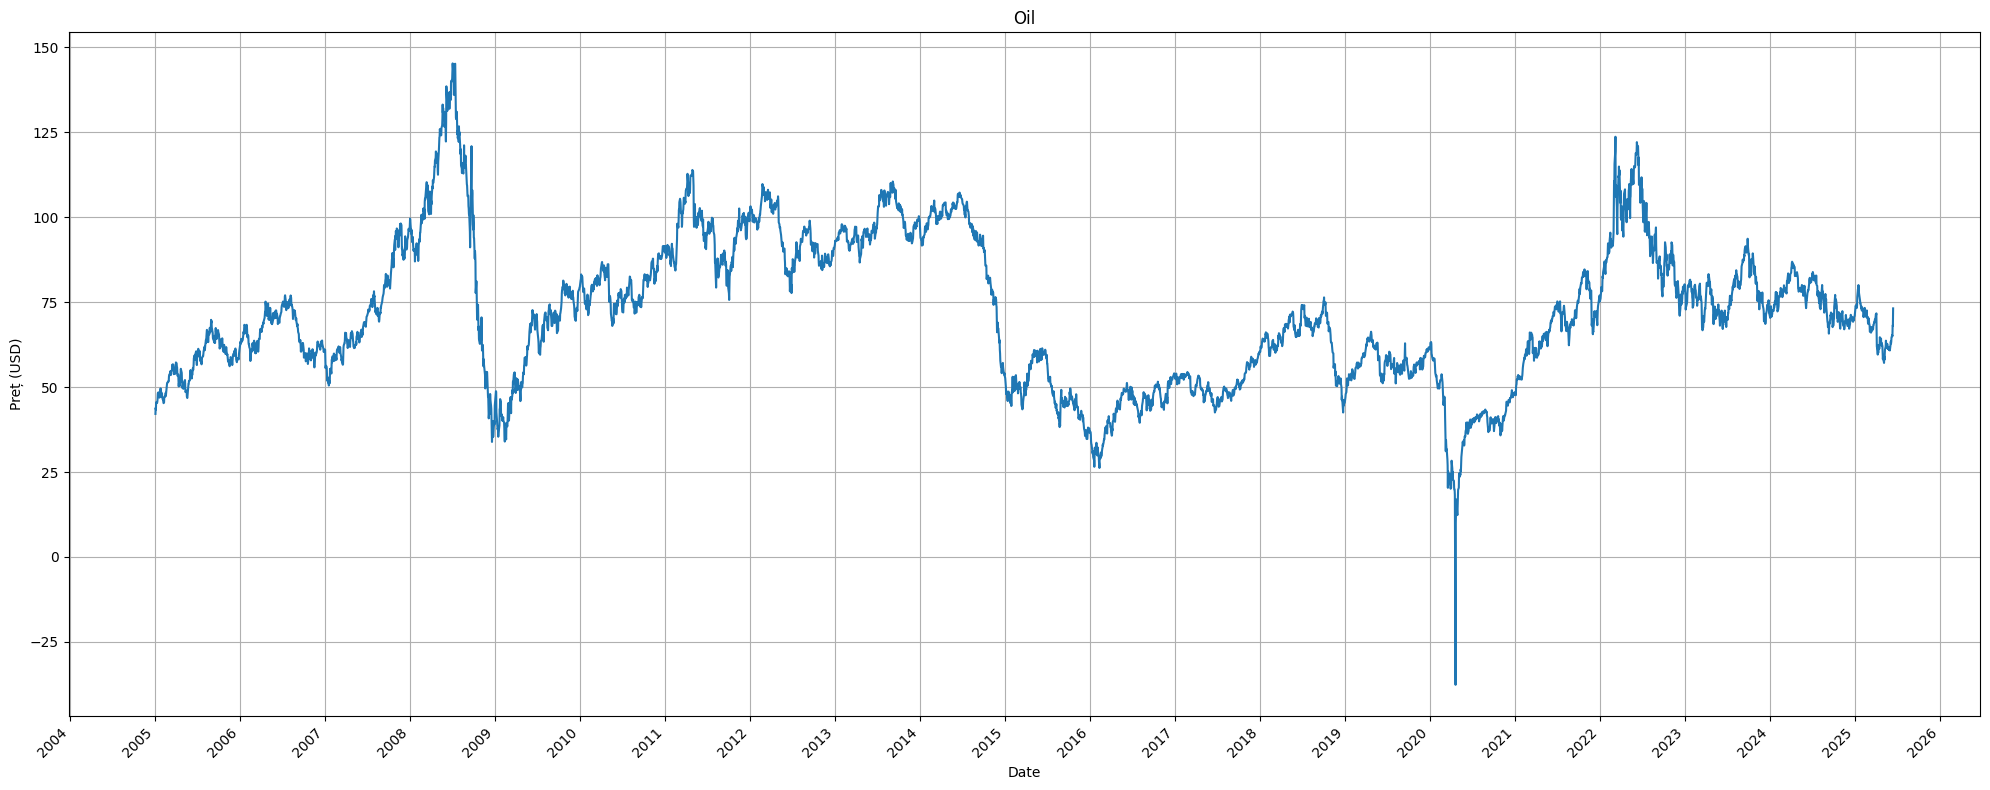

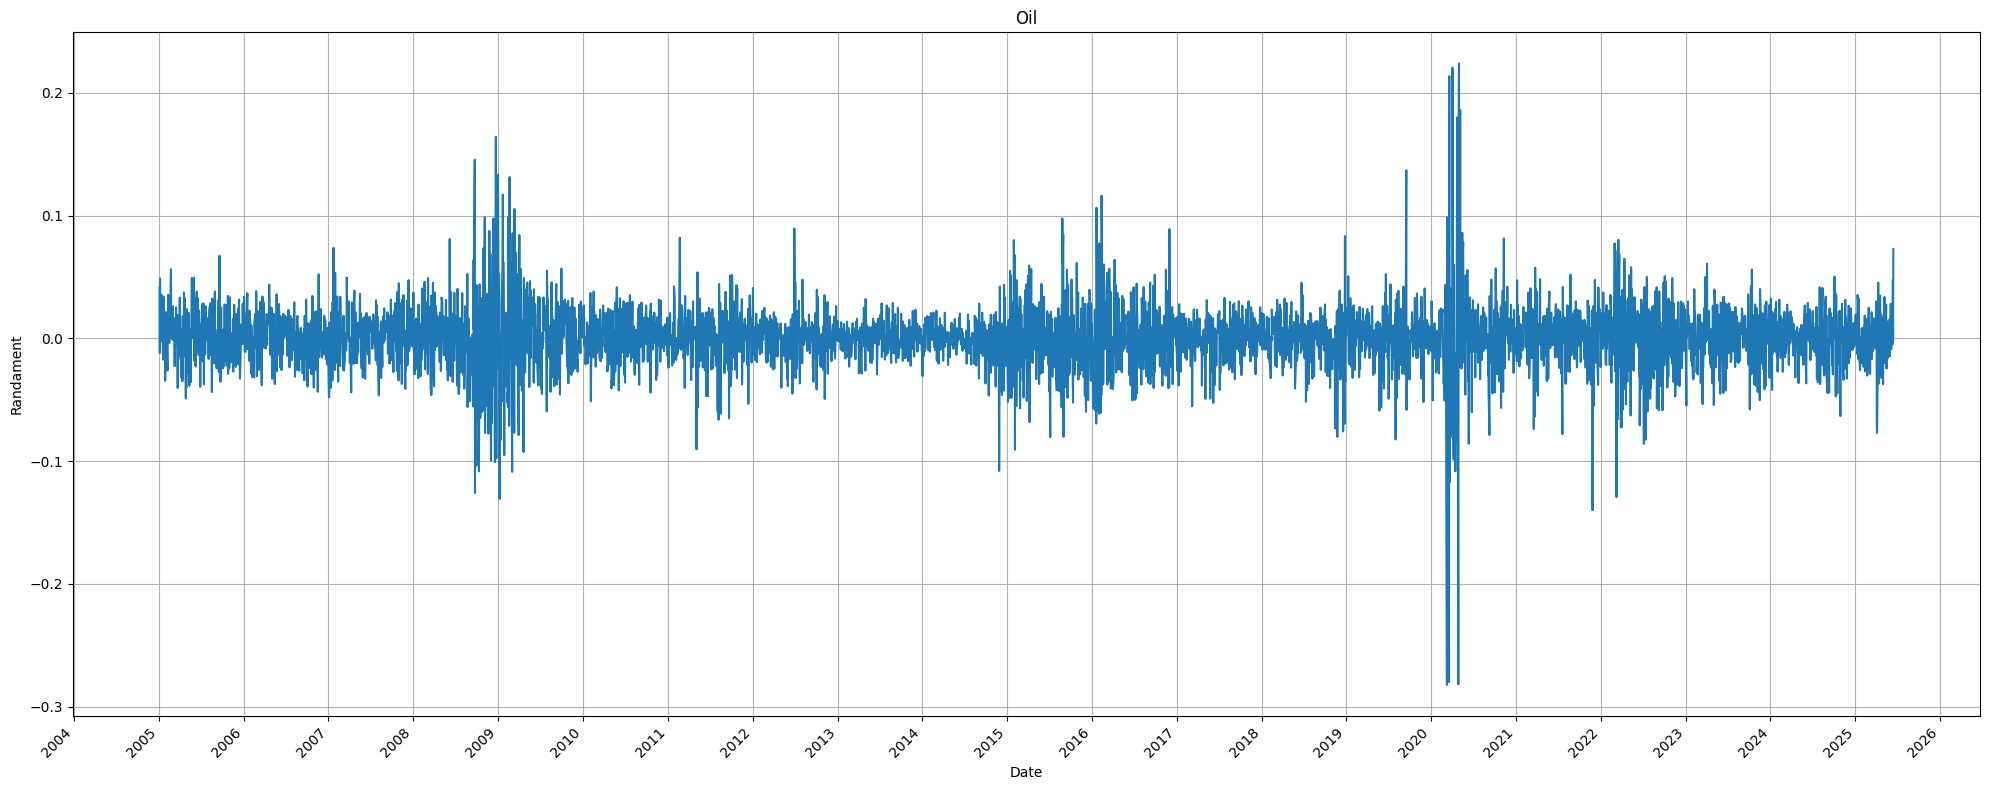

In [ ]:
#Oil plot
fig, ax = plt.subplots(figsize=(20, 8))
oil['Close'].plot(ax=ax, title='Oil', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()


#Oil log randamente
fig, ax = plt.subplots(figsize=(20, 8))
oil_log_returns['Close'].plot(ax=ax, title='Oil', legend=False)
ax.set_ylabel("Randament")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

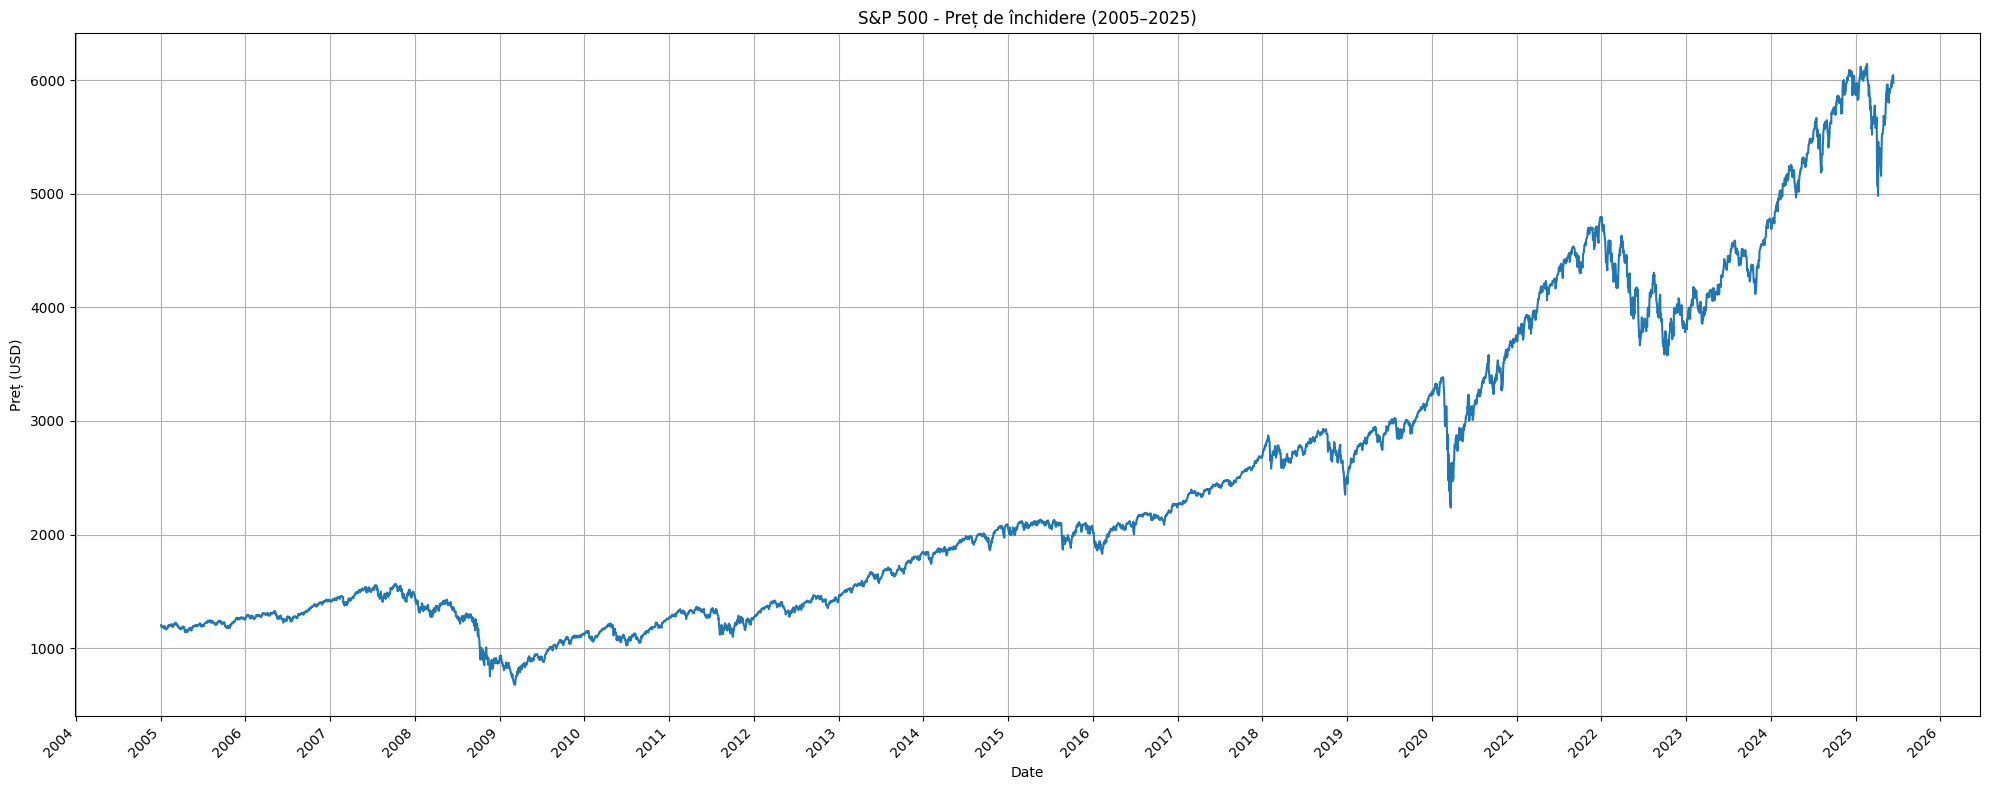

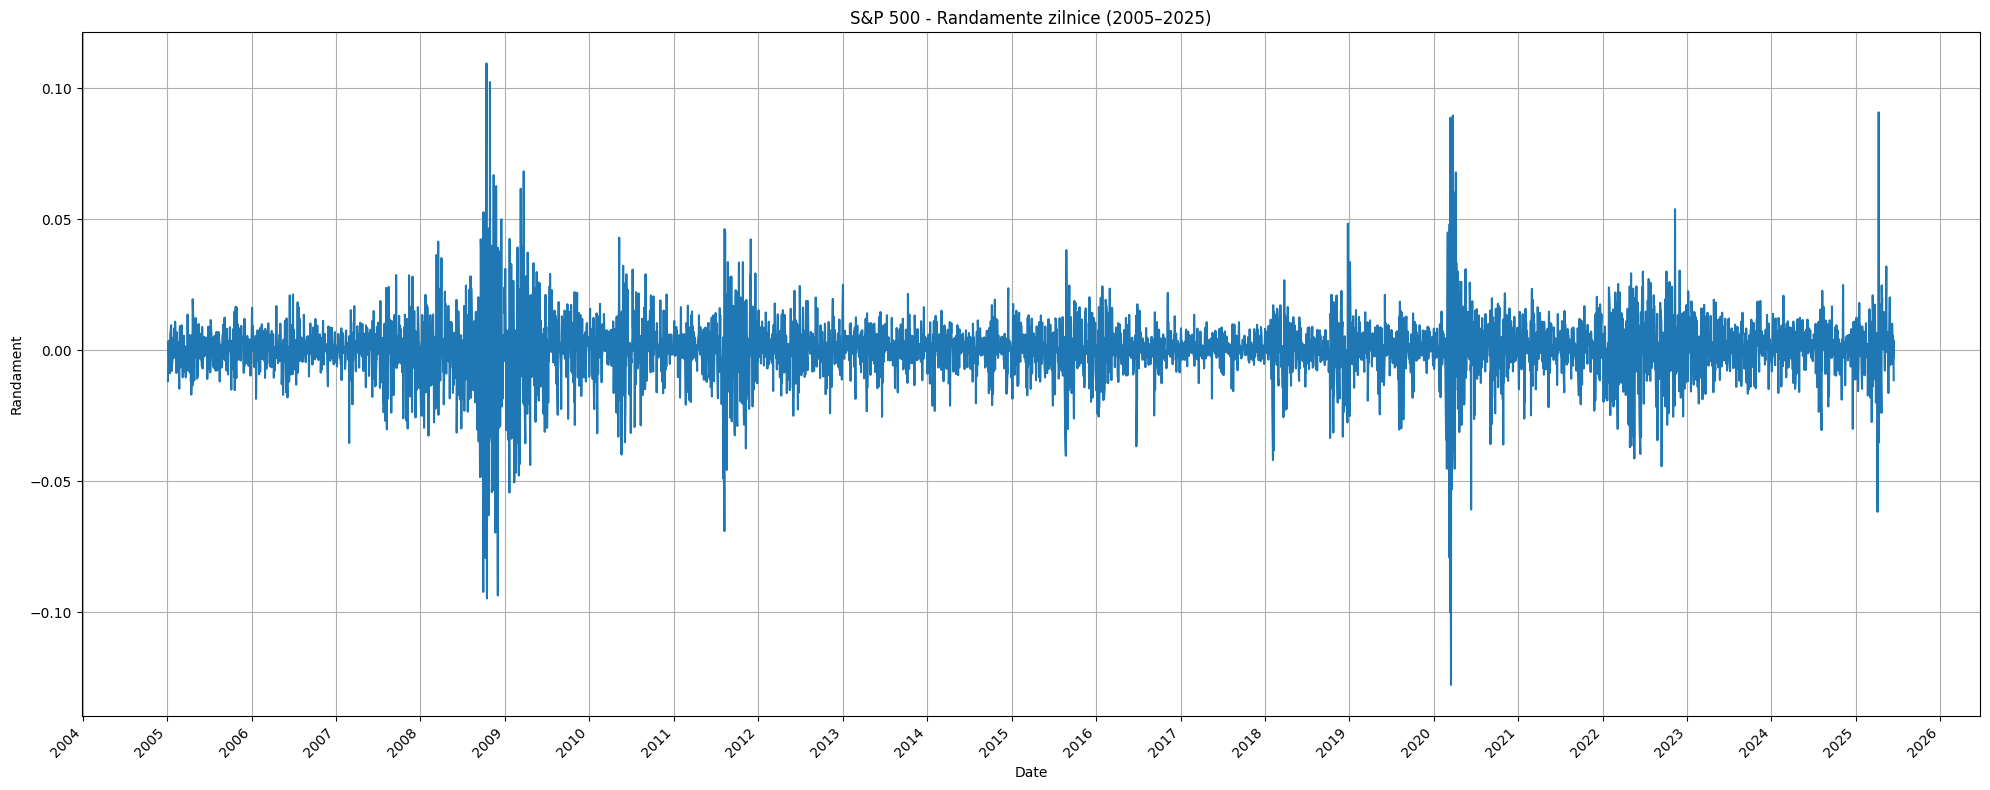

In [ ]:
import matplotlib.pyplot as plt

# === SP500: Preț de închidere ===
fig, ax = plt.subplots(figsize=(20, 8))
sp500['Close'].plot(ax=ax, title='S&P 500 - Preț de închidere (2005–2025)', legend=False)
ax.set_ylabel("Preț (USD)")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

# === SP500: Randamente logaritmice ===
fig, ax = plt.subplots(figsize=(20, 8))
sp500_log_returns['Close'].plot(ax=ax, title='S&P 500 - Randamente zilnice (2005–2025)', legend=False)
ax.set_ylabel("Randament")
ax.grid(True)
ax.tick_params(axis='x', rotation=45)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.tight_layout()
plt.show()

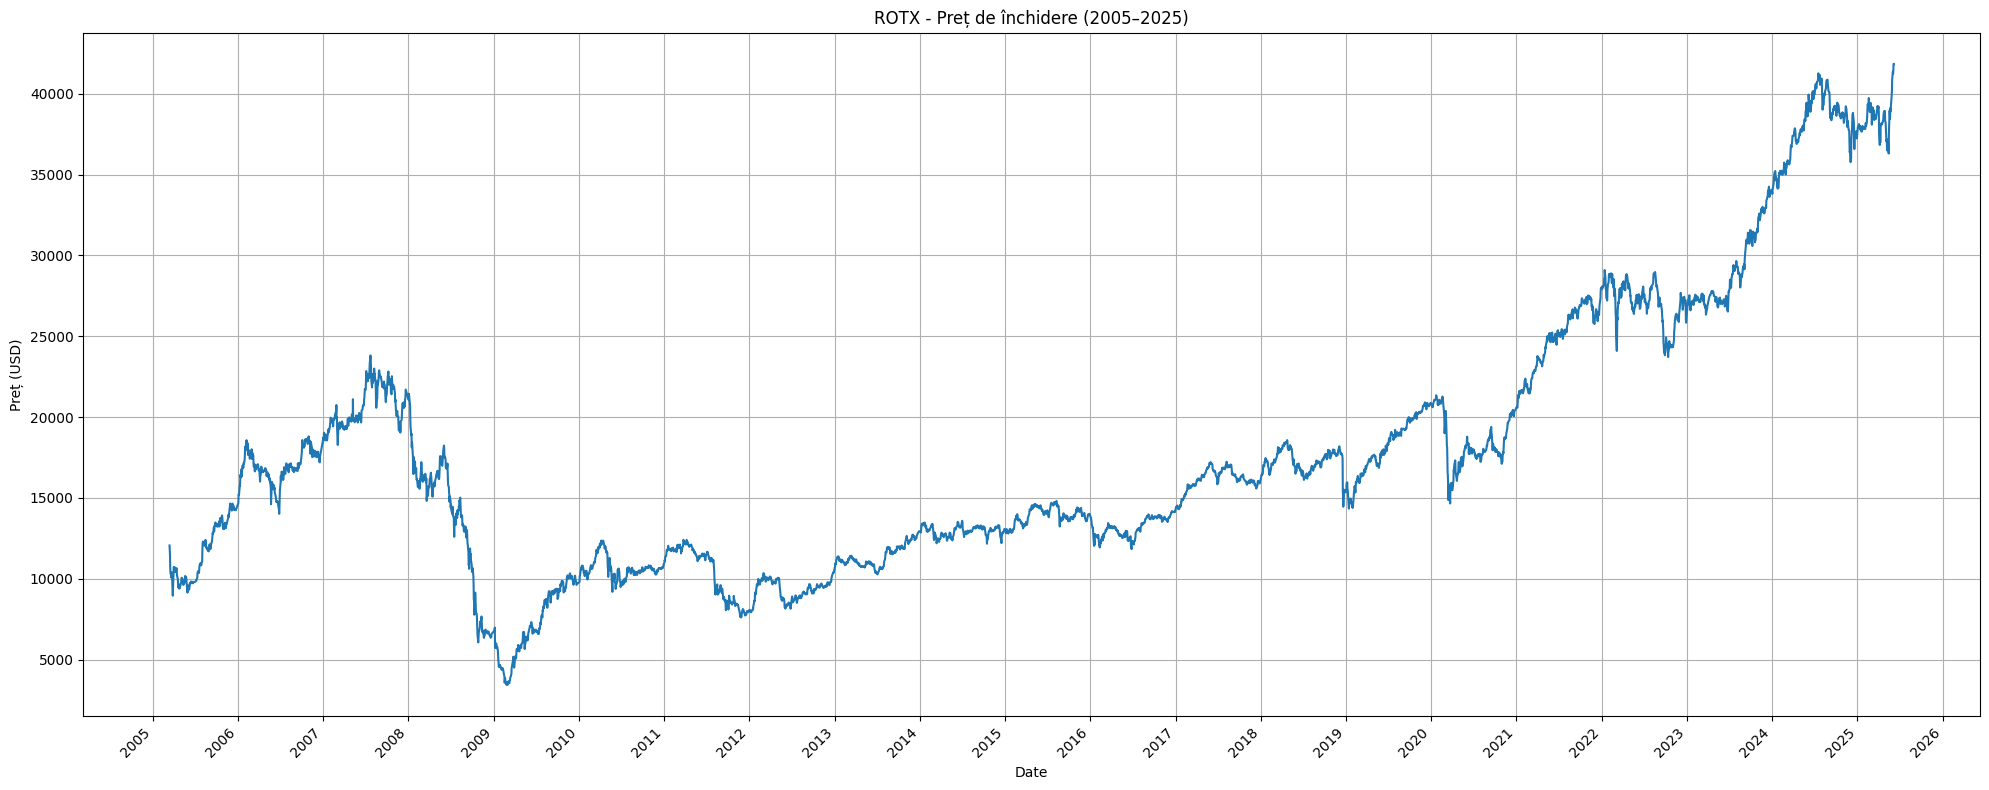

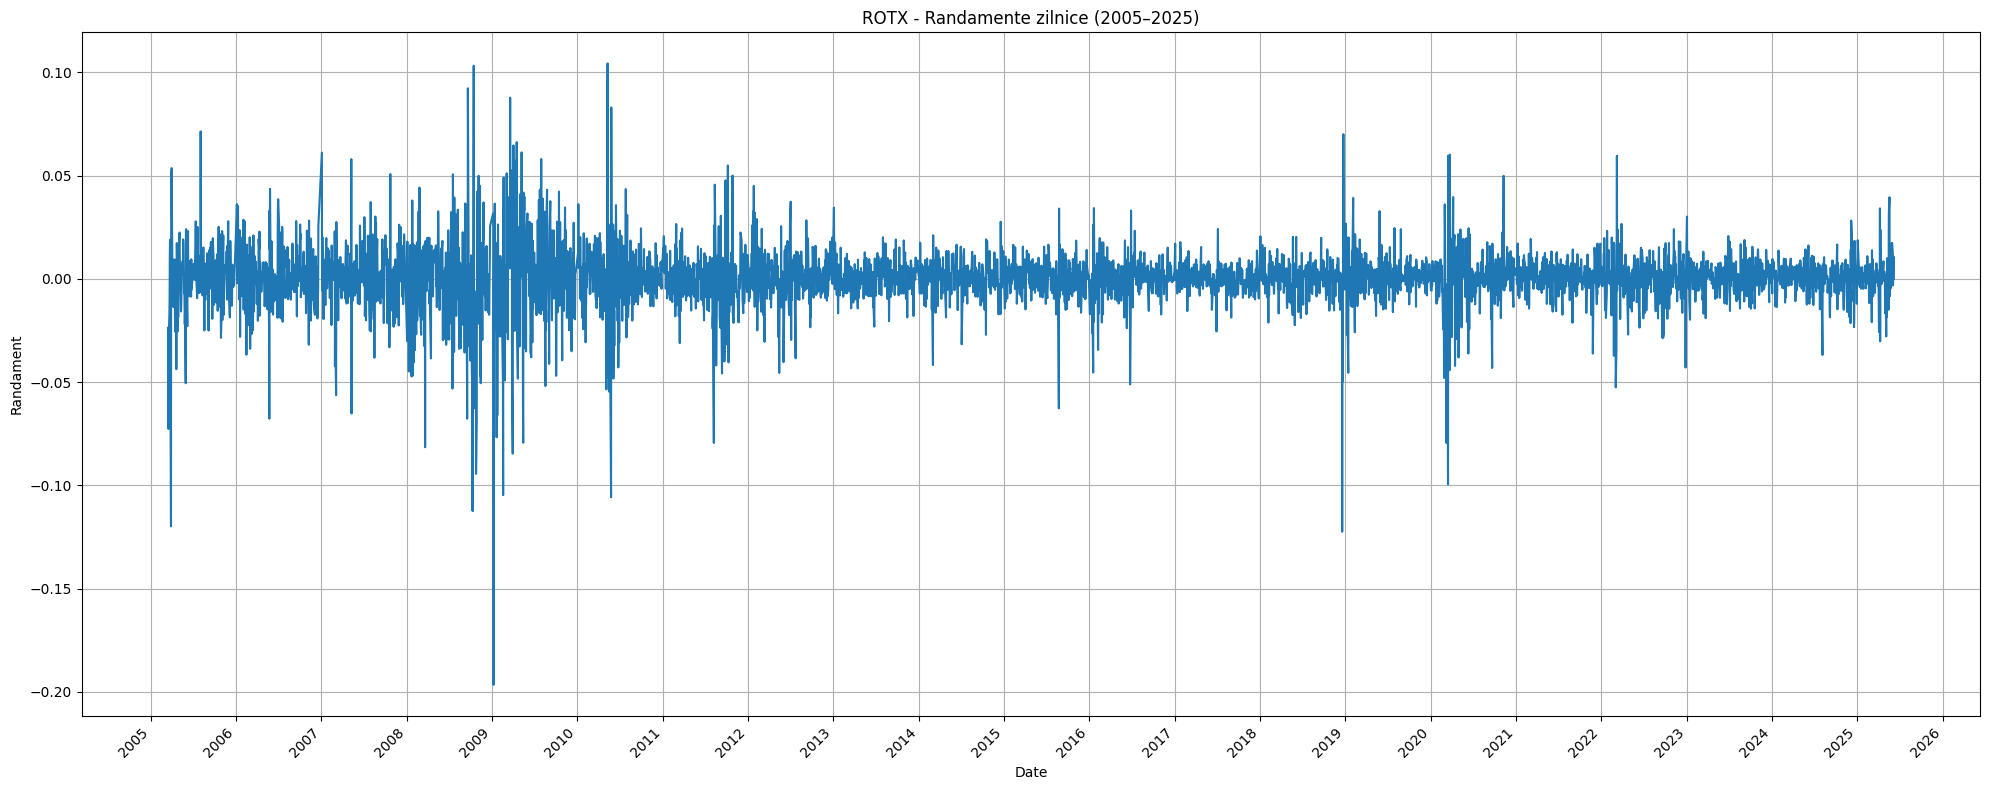

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === ROTX: Preț de închidere ===
plt.figure(figsize=(20, 8))
rotx['Close'].plot(title='ROTX - Preț de închidere (2005–2025)')
plt.ylabel("Preț (USD)")
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # un marcaj pe an
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# === ROTX: Randamente zilnice ===
plt.figure(figsize=(20, 8))
rotx_log_returns['Close'].plot(title='ROTX - Randamente zilnice (2005–2025)')
plt.ylabel("Randament")
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

# **ADF/KPSS/PP**

In [ ]:
def analiza_trend(series, title=''):
    print(f'=== Analiza trend pentru {title} ===\n')

    # 2. Test ADF
    adf = ADF(series, trend='ct')
    print(adf.summary(),'\n')
    adf_stationary = adf.pvalue < 0.05

    # 3. Test KPSS
    kpss_test = KPSS(series, trend='ct')
    print(kpss_test.summary(),'\n')
    kpss_stationary = kpss_test.pvalue > 0.05

    # 4. Test Phillips-Perron
    pp = PhillipsPerron(series, trend='ct')
    print(pp.summary(),'\n')
    pp_stationary = pp.pvalue < 0.05

    # 5. Concluzie automată
    print('--- Concluzie ---')
    if adf_stationary and pp_stationary and kpss_stationary:
        print(f'Seria {title} are un trend determinist.')
    elif not adf_stationary and not pp_stationary and not kpss_stationary:
        print(f'Seria {title} are un trend stochastic.')
    else:
        print(f'Seria {title} necesită o analiză mai detaliată (rezultate mixte între teste).')
    print('=============================\n')

analiza_trend(sp500['Close'], title='S&P 500 - Close')
analiza_trend(sp500_log_returns['Close'], title='S&P 500 - Close')

=== Analiza trend pentru S&P 500 - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.033
P-value                         0.939
Lags                               30
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  2.254
P-value                         0.000
Lags                               43
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.206
P-value                         0.909
Lags                               33
-------------------

In [ ]:
import pandas as pd
from arch.unitroot import ADF, KPSS, PhillipsPerron

def analiza_trend_multi_verdict(df, trends=['c', 'ct']):
    rezultate = []

    for col in df.columns:
        serie = df[col].dropna()

        for trend in trends:
            adf = ADF(serie, trend=trend)
            pp = PhillipsPerron(serie, trend=trend)

            # KPSS acceptă doar 'c' și 'ct'
            kpss_test = KPSS(serie, trend=trend)

            adf_stationary = adf.pvalue < 0.05
            pp_stationary = pp.pvalue < 0.05
            kpss_stationary = kpss_test.pvalue > 0.05

            if adf_stationary and pp_stationary and kpss_stationary:
                verdict = 'Staționară'
            elif not adf_stationary and not pp_stationary and not kpss_stationary:
                verdict = 'Trend stochastic'
            else:
                verdict = 'Mix / incert'

            rezultate.append({
                'Serie': col,
                'Trend': trend,
                'ADF p-value': adf.pvalue,
                'PP p-value': pp.pvalue,
                'KPSS p-value': kpss_test.pvalue,
                'Verdict': verdict
            })

    tabel_verdict = pd.DataFrame(rezultate)
    tabel_verdict.index += 1
    return tabel_verdict


rezultate_finale = analiza_trend_multi_verdict(real_prices_df)
rezultate_finale.head(20)

,Serie,Trend,ADF p-value,PP p-value,KPSS p-value,Verdict
1,SP500,c,0.997953,0.997331,0.000100,Trend stochastic
2,SP500,ct,0.939497,0.909284,0.000100,Trend stochastic
3,Gold,c,0.998798,0.998865,0.000100,Trend stochastic
4,Gold,ct,1.000000,1.000000,0.000100,Trend stochastic
5,Oil,c,0.015947,0.026469,0.002437,Mix / incert
6,Oil,ct,0.058763,0.088905,0.000100,Trend stochastic
7,Bitcoin,c,0.988108,0.996678,0.000100,Trend stochastic
8,Bitcoin,ct,0.923489,0.984478,0.000100,Trend stochastic
9,ROTX,c,0.994356,0.994380,0.000100,Trend stochastic
10,ROTX,ct,0.983316,0.981063,0.000100,Trend stochastic


In [ ]:
rezultate_finale = analiza_trend_multi_verdict(log_real_prices_df)
rezultate_finale.head(20)

,Serie,Trend,ADF p-value,PP p-value,KPSS p-value,Verdict
1,SP500,c,5.612165e-29,0.0,0.342905,Staționară
2,SP500,ct,1.114446e-22,0.0,0.719792,Staționară
3,Gold,c,0.000000e+00,0.0,0.389499,Staționară
4,Gold,ct,0.000000e+00,0.0,0.049107,Mix / incert
5,Oil,c,1.054187e-22,0.0,0.879129,Staționară
6,Oil,ct,1.668701e-19,0.0,0.629769,Staționară
7,Bitcoin,c,4.298329e-20,0.0,0.017850,Mix / incert
8,Bitcoin,ct,8.045018e-18,0.0,0.152165,Staționară
9,ROTX,c,1.147040e-20,0.0,0.301188,Staționară
10,ROTX,ct,5.295654e-18,0.0,0.595757,Staționară


In [ ]:
analiza_trend(rotx['Close'], title='ROTX - Close')
analiza_trend(rotx_log_returns['Close'], title='ROTX - Close')

=== Analiza trend pentru ROTX - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                 -0.503
P-value                         0.983
Lags                                2
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  2.135
P-value                         0.000
Lags                               42
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.556
P-value                         0.981
Lags                               32
----------------------

In [ ]:
analiza_trend(gold['Close'], title='GOLD - Close')
analiza_trend(gold_log_returns['Close'], title='GOLD - Close')

=== Analiza trend pentru GOLD - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                  1.017
P-value                         1.000
Lags                               31
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  1.041
P-value                         0.000
Lags                               43
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                  1.012
P-value                         1.000
Lags                               33
----------------------

In [ ]:
analiza_trend(oil['Close'], title='OIL - Close')
analiza_trend(oil_log_returns['Close'], title='OIL - Close')

=== Analiza trend pentru OIL - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                 -3.348
P-value                         0.059
Lags                               29
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  0.642
P-value                         0.000
Lags                               43
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.178
P-value                         0.089
Lags                               33
-----------------------

In [ ]:
analiza_trend(bitcoin['Close'], title='BITCOIN - Close')
analiza_trend(bitcoin_log_returns['Close'], title='BITCOIN - Close')

=== Analiza trend pentru BITCOIN - Close ===

   Augmented Dickey-Fuller Results   
Test Statistic                 -1.132
P-value                         0.923
Lags                               31
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

    KPSS Stationarity Test Results   
Test Statistic                  1.496
P-value                         0.000
Lags                               43
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root. 

     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.472
P-value                         0.984
Lags                               33
-------------------

# **ACF/PACF**

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=20, title_prefix=''):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    plot_acf(series, lags=lags, ax=axes[0], markersize=4)
    axes[0].set_title(f'ACF - {title_prefix}')

    plot_pacf(series, lags=lags, ax=axes[1], markersize=4)
    axes[1].set_title(f'PACF - {title_prefix}')

    plt.tight_layout()
    plt.show()


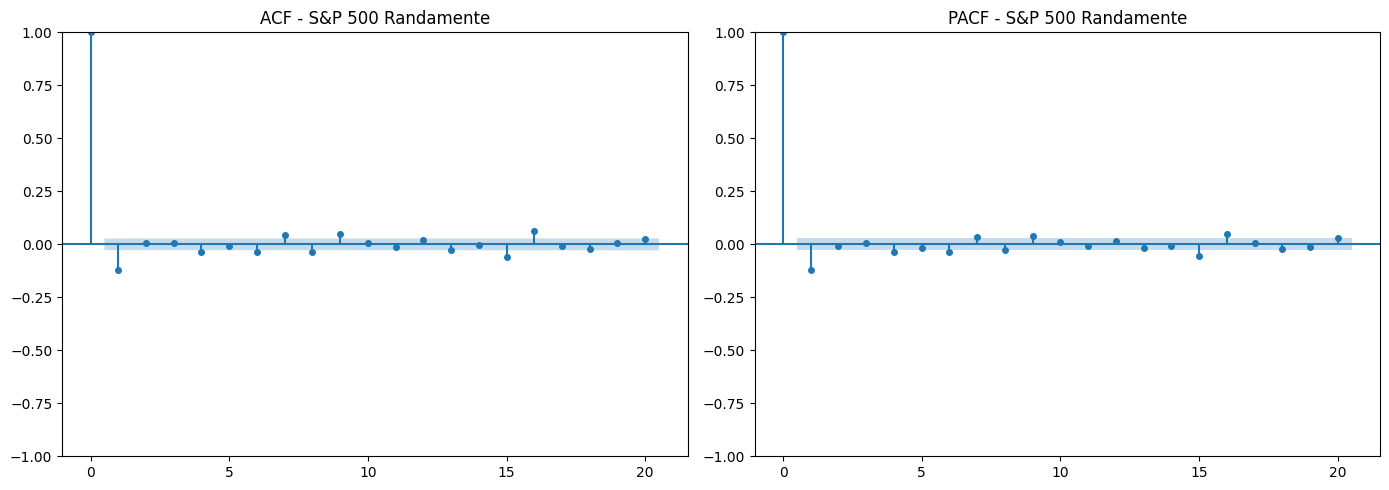

In [ ]:
plot_acf_pacf(sp500_log_returns['Close'], lags=20, title_prefix='S&P 500 Randamente')

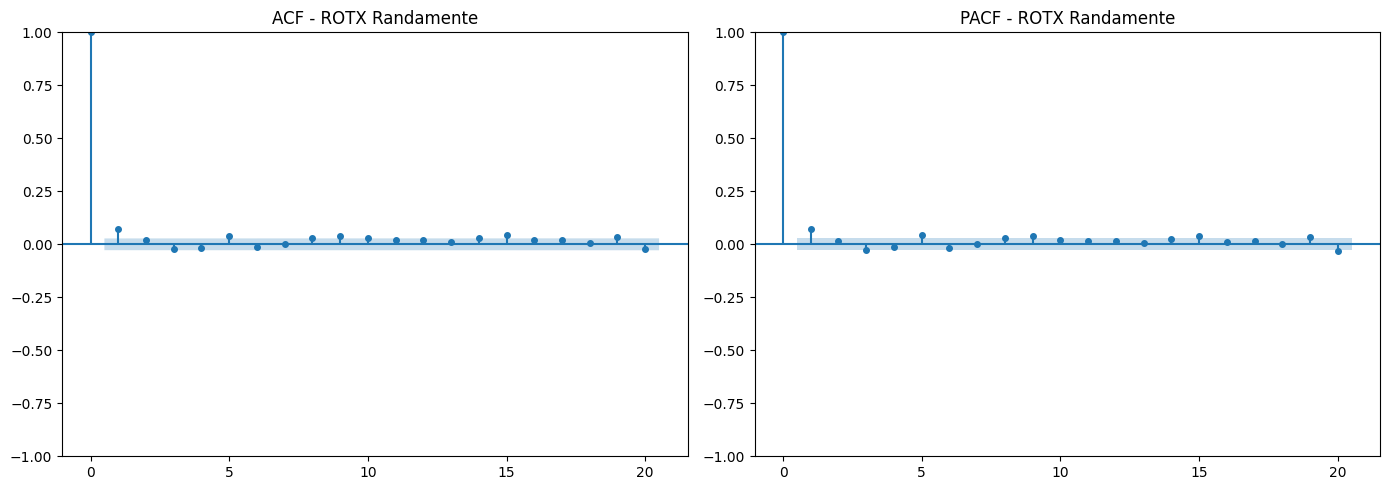

In [ ]:
plot_acf_pacf(rotx_log_returns['Close'], lags=20, title_prefix='ROTX Randamente')

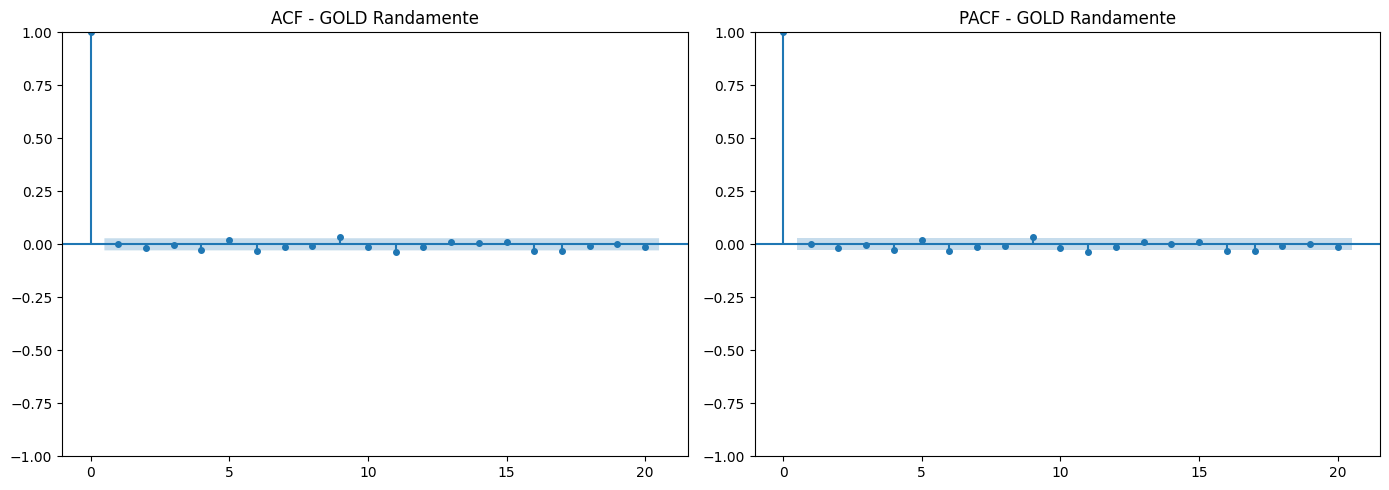

In [ ]:
plot_acf_pacf(gold_log_returns['Close'], lags=20, title_prefix='GOLD Randamente')

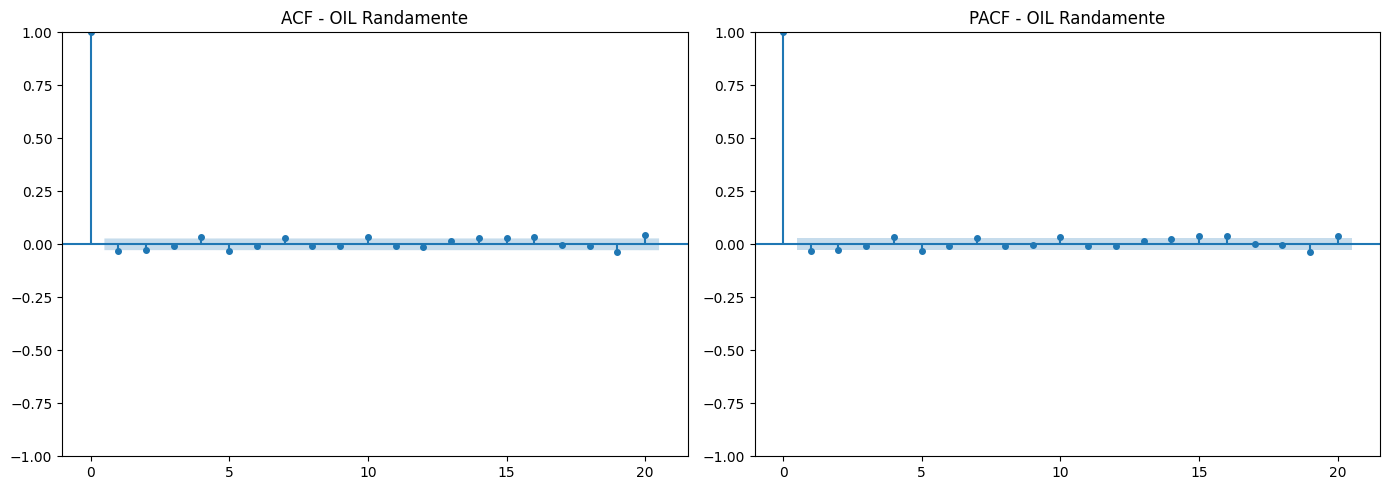

In [ ]:
plot_acf_pacf(oil_log_returns['Close'], lags=20, title_prefix='OIL Randamente')

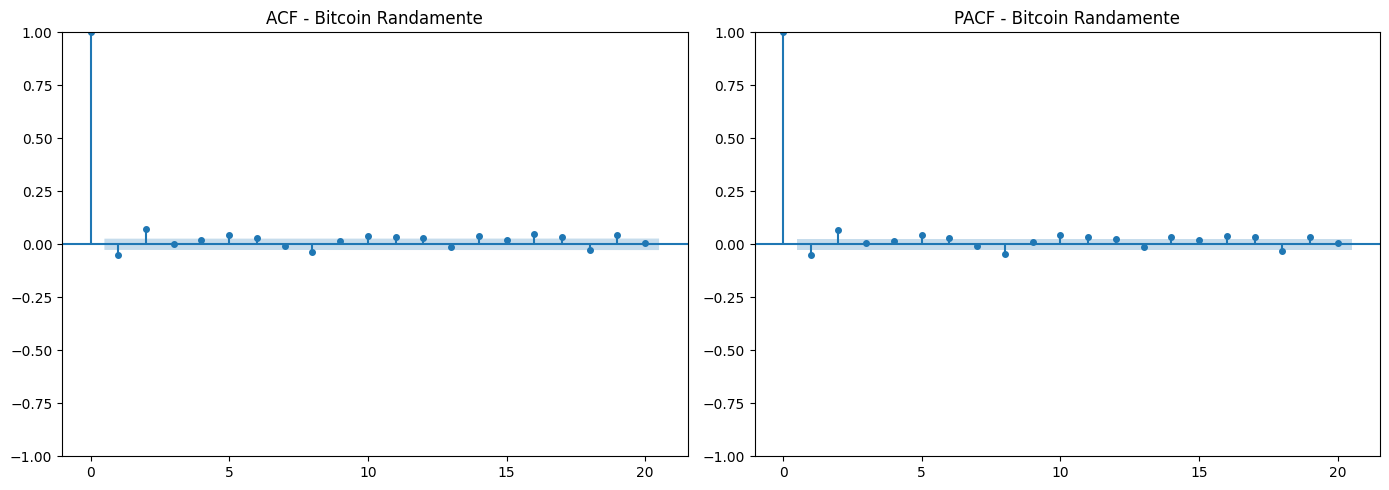

In [ ]:
plot_acf_pacf(bitcoin_log_returns['Close'], lags=20, title_prefix='Bitcoin Randamente')

# **MODELE ARMA/ARIMA**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import kurtosis, skew
import numpy as np
import pandas as pd
import warnings

def testeaza_modele_arima(serie, p_max=3, d=0, q_max=3, alpha=0.05):
    rezultate = []

    for p in range(p_max + 1):
        for q in range(q_max + 1):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")

                    model = ARIMA(serie, order=(p, d, q))
                    fitted = model.fit()
                    resid = fitted.resid.dropna()

                    p_values = fitted.pvalues
                    nr_semnificativi = (p_values < alpha).sum()

                    rezultate.append({
                        'Model': f'ARIMA({p},{d},{q})',
                        'AIC': fitted.aic,
                        'BIC': fitted.bic,
                        'HQIC': fitted.hqic,
                        'LogLik': fitted.llf,
                        'Num_Params': len(fitted.params),
                        'Coef_Signif': nr_semnificativi,
                        'Sigma2': np.var(resid, ddof=1),
                        'Skewness': skew(resid),
                        'Kurtosis': kurtosis(resid),
                    })

            except Exception:
                continue

    df_rezultate = pd.DataFrame(rezultate)

    # Adăugăm coloana All_Significant
    df_rezultate['All_Significant'] = df_rezultate['Coef_Signif'] == df_rezultate['Num_Params']

    # Sortăm: întâi toate modelele complet semnificative, apoi după AIC
    df_rezultate = df_rezultate.sort_values(by=['All_Significant', 'AIC'], ascending=[False, True]).reset_index(drop=True)

    return df_rezultate


testeaza_modele_arima(sp500_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(2,0,1)",-30576.220693,-30543.526898,-30564.774536,15293.110346,5,5,0.000147,-0.632146,12.173521,True
1,"ARIMA(0,0,1)",-30575.832710,-30556.216433,-30568.965016,15290.916355,3,3,0.000147,-0.640434,12.239181,True
2,"ARIMA(1,0,0)",-30575.633003,-30556.016726,-30568.765309,15290.816502,3,3,0.000147,-0.620005,12.301743,True
3,"ARIMA(2,0,0)",-30574.050875,-30547.895839,-30564.893950,15291.025438,4,3,0.000147,-0.631499,12.255814,False
4,"ARIMA(1,0,1)",-30574.018339,-30547.863303,-30564.861413,15291.009169,4,2,0.000147,-0.631604,12.260915,False
5,"ARIMA(0,0,2)",-30574.009481,-30547.854445,-30564.852556,15291.004741,4,3,0.000147,-0.633343,12.253797,False
6,"ARIMA(3,0,0)",-30572.326189,-30539.632394,-30560.880032,15291.163095,5,2,0.000147,-0.620692,12.230281,False
7,"ARIMA(1,0,2)",-30572.009516,-30539.315721,-30560.563359,15291.004758,5,1,0.000147,-0.633346,12.253803,False
8,"ARIMA(0,0,3)",-30571.733425,-30539.039630,-30560.287268,15290.866712,5,2,0.000147,-0.622527,12.240924,False
9,"ARIMA(3,0,3)",-30570.748455,-30518.438383,-30552.434604,15293.374227,8,3,0.000147,-0.682314,12.131816,False


In [ ]:
best_model_sp500_arima = ARIMA(sp500_log_returns['Close'], order=(2, 0, 1))
best_fitted_sp500 = best_model_sp500_arima.fit()
print(best_fitted_sp500.summary())

r_sp500 = best_fitted_sp500.resid
rsq_sp500 = r_sp500**2
rsq_sp500.head()

                               SARIMAX Results                                
Dep. Variable:                  ^GSPC   No. Observations:                 5109
Model:                 ARIMA(2, 0, 1)   Log Likelihood               15293.110
Date:                Sun, 15 Jun 2025   AIC                         -30576.221
Time:                        15:56:29   BIC                         -30543.527
Sample:                             0   HQIC                        -30564.775
                               - 5109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      2.017      0.044    8.95e-06       0.001
ar.L1         -0.9330      0.138     -6.757      0.000      -1.204      -0.662
ar.L2         -0.1066      0.014     -7.367      0.0

,0
Date,
2005-01-04,0.000145
2005-01-05,0.000029
2005-01-06,0.000007
2005-01-07,0.000002
2005-01-10,0.000008


In [ ]:
testeaza_modele_arima(rotx_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(3,0,3)",-28155.876511,-28103.726175,-28137.600118,14085.938255,8,7,0.000211,-1.178737,16.445148,False
1,"ARIMA(2,0,2)",-28154.077945,-28114.965194,-28140.370651,14083.038973,6,3,0.000211,-1.185140,16.516408,False
2,"ARIMA(2,0,3)",-28153.915245,-28108.283702,-28137.923401,14083.957622,7,6,0.000211,-1.154814,16.554306,False
3,"ARIMA(3,0,0)",-28149.478162,-28116.884203,-28138.055417,14079.739081,5,4,0.000212,-1.174715,16.597652,False
4,"ARIMA(0,0,3)",-28149.391031,-28116.797071,-28137.968285,14079.695515,5,4,0.000212,-1.175354,16.596444,False
5,"ARIMA(1,0,0)",-28149.311606,-28129.755231,-28142.457959,14077.655803,3,2,0.000212,-1.153914,16.643982,False
6,"ARIMA(0,0,2)",-28148.981275,-28122.906108,-28139.843079,14078.490638,4,3,0.000212,-1.147458,16.654663,False
7,"ARIMA(2,0,0)",-28148.449674,-28122.374507,-28139.311478,14078.224837,4,3,0.000212,-1.139642,16.663608,False
8,"ARIMA(0,0,1)",-28148.272565,-28128.716190,-28141.418918,14077.136283,3,2,0.000212,-1.162486,16.634376,False
9,"ARIMA(1,0,1)",-28147.940226,-28121.865058,-28138.802029,14077.970113,4,2,0.000212,-1.147717,16.655788,False


In [ ]:
best_model_rotx_arima = ARIMA(rotx_log_returns['Close'], order=( 3, 0, 3))
best_fitted_rotx = best_model_rotx_arima.fit()
print(best_fitted_rotx.summary())

r_rotx = best_fitted_rotx.resid
rsq_rotx = r_rotx**2
rsq_rotx.head()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5008
Model:                 ARIMA(3, 0, 3)   Log Likelihood               14085.938
Date:                Sun, 15 Jun 2025   AIC                         -28155.877
Time:                        15:57:21   BIC                         -28103.726
Sample:                             0   HQIC                        -28137.600
                               - 5008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.975      0.330      -0.000       0.001
ar.L1         -1.1350      0.135     -8.413      0.000      -1.399      -0.871
ar.L2         -0.9645      0.086    -11.279      0.0

,0
Date,
2005-03-15,0.000573
2005-03-16,0.000596
2005-03-17,0.005016
2005-03-18,0.000598
2005-03-21,0.000253


In [ ]:
testeaza_modele_arima(gold_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(0,0,0)",-28796.424572,-28783.513936,-28791.885390,14400.212286,2,2,0.000128,-0.306643,5.343651,True
1,"ARIMA(1,0,0)",-28794.431464,-28775.065511,-28787.622691,14400.215732,3,2,0.000128,-0.306317,5.340505,False
2,"ARIMA(0,0,1)",-28794.431447,-28775.065493,-28787.622673,14400.215723,3,2,0.000128,-0.306367,5.340983,False
3,"ARIMA(0,0,2)",-28794.061898,-28768.240627,-28784.983534,14401.030949,4,2,0.000128,-0.308283,5.360355,False
4,"ARIMA(2,0,0)",-28793.979088,-28768.157817,-28784.900723,14400.989544,4,2,0.000128,-0.308224,5.359700,False
5,"ARIMA(2,0,3)",-28793.582389,-28748.395164,-28777.695251,14403.791194,7,4,0.000128,-0.308410,5.345793,False
6,"ARIMA(1,0,2)",-28792.434676,-28760.158087,-28781.086720,14401.217338,5,2,0.000128,-0.307735,5.348221,False
7,"ARIMA(1,0,1)",-28792.414128,-28766.592856,-28783.335763,14400.207064,4,2,0.000128,-0.306355,5.340851,False
8,"ARIMA(2,0,1)",-28792.137618,-28759.861029,-28780.789663,14401.068809,5,2,0.000128,-0.308362,5.365271,False
9,"ARIMA(0,0,3)",-28792.086715,-28759.810126,-28780.738759,14401.043358,5,2,0.000128,-0.308401,5.364383,False


In [ ]:
best_fitted_gold_arima = ARIMA(gold_log_returns['Close'], order=( 1, 0, 1))
best_fitted_gold = best_fitted_gold_arima.fit()
print(best_fitted_gold.summary())

#Reziduuri normale si la patrat
r_gold = best_fitted_gold.resid
rsq_gold = r_gold**2
rsq_gold.head()

                               SARIMAX Results                                
Dep. Variable:                   GC=F   No. Observations:                 4700
Model:                 ARIMA(1, 0, 1)   Log Likelihood               14400.207
Date:                Sun, 15 Jun 2025   AIC                         -28792.414
Time:                        15:58:02   BIC                         -28766.593
Sample:                             0   HQIC                        -28783.336
                               - 4700                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.289      0.022    5.48e-05       0.001
ar.L1          0.1139     12.269      0.009      0.993     -23.933      24.161
ma.L1         -0.1130     12.271     -0.009      0.9

,0
Date,
2005-01-04,7.181515e-07
2005-01-05,2.327063e-05
2005-01-06,1.847026e-04
2005-01-14,2.132489e-05
2005-01-27,3.175194e-06


In [ ]:
testeaza_modele_arima(oil_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(2,0,3)",-22586.608094,-22540.913932,-22570.601557,11300.304047,7,6,0.000669,-0.313153,14.709711,False
1,"ARIMA(3,0,2)",-22583.819858,-22538.125696,-22567.813321,11298.909929,7,6,0.000669,-0.317477,15.177942,False
2,"ARIMA(2,0,0)",-22583.478639,-22557.367689,-22574.332046,11295.739319,4,3,0.000670,-0.304203,15.139429,False
3,"ARIMA(0,0,2)",-22583.355851,-22557.244901,-22574.209258,11295.677925,4,3,0.000670,-0.304804,15.131855,False
4,"ARIMA(1,0,3)",-22582.574025,-22543.407600,-22568.854136,11297.287012,6,5,0.000669,-0.327561,15.099328,False
5,"ARIMA(0,0,1)",-22582.401329,-22562.818117,-22575.541384,11294.200664,3,2,0.000670,-0.291313,15.296708,False
6,"ARIMA(1,0,0)",-22582.152442,-22562.569230,-22575.292497,11294.076221,3,2,0.000670,-0.290334,15.300282,False
7,"ARIMA(3,0,0)",-22581.749873,-22549.111186,-22570.316632,11295.874936,5,3,0.000670,-0.311537,15.108114,False
8,"ARIMA(1,0,1)",-22581.569005,-22555.458055,-22572.422412,11294.784503,4,3,0.000670,-0.322021,15.179687,False
9,"ARIMA(0,0,3)",-22581.499157,-22548.860470,-22570.065916,11295.749579,5,3,0.000670,-0.311071,15.115032,False


In [ ]:
best_model_oil_arima = ARIMA(oil_log_returns['Close'], order=( 2, 0, 3))
best_fitted_oil = best_model_oil_arima.fit()
print(best_fitted_oil.summary())

r_oil = best_fitted_oil.resid
rsq_oil = r_oil**2
rsq_oil.head()

                               SARIMAX Results                                
Dep. Variable:                   CL=F   No. Observations:                 5053
Model:                 ARIMA(2, 0, 3)   Log Likelihood               11300.304
Date:                Sun, 15 Jun 2025   AIC                         -22586.608
Time:                        15:59:06   BIC                         -22540.914
Sample:                             0   HQIC                        -22570.602
                               - 5053                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.411      0.681      -0.001       0.001
ar.L1         -0.9131      0.036    -25.610      0.000      -0.983      -0.843
ar.L2         -0.9037      0.035    -25.814      0.0

,0
Date,
2005-01-04,0.001720
2005-01-05,0.000117
2005-01-06,0.002400
2005-01-07,0.000002
2005-01-10,0.000006


In [ ]:
testeaza_modele_arima(bitcoin_log_returns['Close'])

,Model,AIC,BIC,HQIC,LogLik,Num_Params,Coef_Signif,Sigma2,Skewness,Kurtosis,All_Significant
0,"ARIMA(2,0,2)",-17542.890276,-17503.292110,-17529.069556,8777.445138,6,6,0.002310,-1.158703,22.128112,True
1,"ARIMA(2,0,0)",-17521.957094,-17495.558317,-17512.743281,8764.978547,4,4,0.002320,-0.991257,21.564697,True
2,"ARIMA(0,0,2)",-17521.084662,-17494.685884,-17511.870848,8764.542331,4,4,0.002321,-0.993053,21.597563,True
3,"ARIMA(1,0,1)",-17509.371874,-17482.973096,-17500.158061,8758.685937,4,4,0.002326,-0.963474,21.097756,True
4,"ARIMA(1,0,0)",-17497.983156,-17478.184072,-17491.072796,8751.991578,3,3,0.002331,-0.974805,21.247043,True
5,"ARIMA(0,0,1)",-17496.231405,-17476.432321,-17489.321045,8751.115702,3,3,0.002332,-0.980377,21.324854,True
6,"ARIMA(0,0,0)",-17485.814598,-17472.615210,-17481.207692,8744.907299,2,2,0.002338,-1.018020,21.948825,True
7,"ARIMA(2,0,3)",-17537.147861,-17490.950001,-17521.023688,8775.573931,7,6,0.002311,-1.148083,22.134254,False
8,"ARIMA(3,0,2)",-17521.758525,-17475.560665,-17505.634352,8767.879263,7,4,0.002318,-1.025984,21.685010,False
9,"ARIMA(1,0,3)",-17521.499784,-17481.901617,-17507.679064,8766.749892,6,5,0.002319,-1.019524,21.890932,False


In [ ]:
best_model_bitcoin_arima = ARIMA(bitcoin_log_returns['Close'], order=( 2, 0, 2))
best_fitted_bitcoin = best_model_bitcoin_arima.fit()
print(best_fitted_bitcoin.summary())

r_bitcoin = best_fitted_bitcoin.resid
rsq_bitcoin = r_bitcoin**2
rsq_bitcoin.head()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5430
Model:                 ARIMA(2, 0, 2)   Log Likelihood                8777.445
Date:                Sun, 15 Jun 2025   AIC                         -17542.890
Time:                        16:00:22   BIC                         -17503.292
Sample:                    07-14-2010   HQIC                        -17529.070
                         - 05-25-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      2.378      0.017       0.000       0.005
ar.L1          0.4846      0.064      7.590      0.000       0.359       0.610
ar.L2          0.4645      0.066      7.065      0.0

,0
Date,
2010-07-14,0.000316
2010-07-15,0.000351
2010-07-16,0.019951
2010-07-17,0.000018
2010-07-18,0.027282


# **TESTE ARCH-LM SI IPOTEZE FUNDAMENTALE**

In [ ]:
from statsmodels.stats.diagnostic import het_arch

def arch_lm_test(serie, nlags=10, titlu=None):
    """
    Aplică testul ARCH-LM (Engle) pentru heteroscedasticitate condiționată.

    Parametri:
    - serie: pd.Series cu randamente sau reziduuri
    - nlags: numărul de laguri pentru test (default: 10)
    - titlu: nume opțional pentru afișare

    Returnează:
    - dict cu valorile statistice
    """
    serie = serie.dropna()
    lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(serie, nlags=nlags)

    print(f"\n=== Test ARCH-LM pentru {titlu} ===")
    if titlu:
        print(f"Serie: {titlu}")
    print(f"LM Statistic     : {lm_stat:.4f}")
    print(f"LM p-value       : {lm_pvalue:.4f}")
    print(f"F Statistic      : {f_stat:.4f}")
    print(f"F p-value        : {f_pvalue:.4f}")

    # === Concluzie automată ===
    print("-----------------------------------")
    if lm_pvalue < 0.05 or f_pvalue < 0.05:
        print("Se respinge H₀ ⇒ există heteroscedasticitate (ARCH efect detectat)")
        print("Model GARCH este justificat.")
    else:
        print("Rezultat: Nu se respinge H₀ ⇒ nu există dovezi de heteroscedasticitate")
        print("Recomandare: Varianța reziduurilor pare constantă.")
    print("===================================")


arch_lm_test(r_bitcoin, nlags=12, titlu="Bitcoin")
arch_lm_test(r_oil, nlags=12, titlu="Oil")
arch_lm_test(r_gold, nlags=12, titlu="Gold")
arch_lm_test(r_rotx, nlags=12, titlu="ROTX")
arch_lm_test(r_sp500, nlags=12, titlu="S&P 500")


=== Test ARCH-LM pentru Bitcoin ===
Serie: Bitcoin
LM Statistic     : 487.1493
LM p-value       : 0.0000
F Statistic      : 44.4995
F p-value        : 0.0000
-----------------------------------
Se respinge H₀ ⇒ există heteroscedasticitate (ARCH efect detectat)
Model GARCH este justificat.

=== Test ARCH-LM pentru Oil ===
Serie: Oil
LM Statistic     : 1028.4951
LM p-value       : 0.0000
F Statistic      : 107.3991
F p-value        : 0.0000
-----------------------------------
Se respinge H₀ ⇒ există heteroscedasticitate (ARCH efect detectat)
Model GARCH este justificat.

=== Test ARCH-LM pentru Gold ===
Serie: Gold
LM Statistic     : 304.2000
LM p-value       : 0.0000
F Statistic      : 27.0339
F p-value        : 0.0000
-----------------------------------
Se respinge H₀ ⇒ există heteroscedasticitate (ARCH efect detectat)
Model GARCH este justificat.

=== Test ARCH-LM pentru ROTX ===
Serie: ROTX
LM Statistic     : 490.3254
LM p-value       : 0.0000
F Statistic      : 45.1892
F p-value   

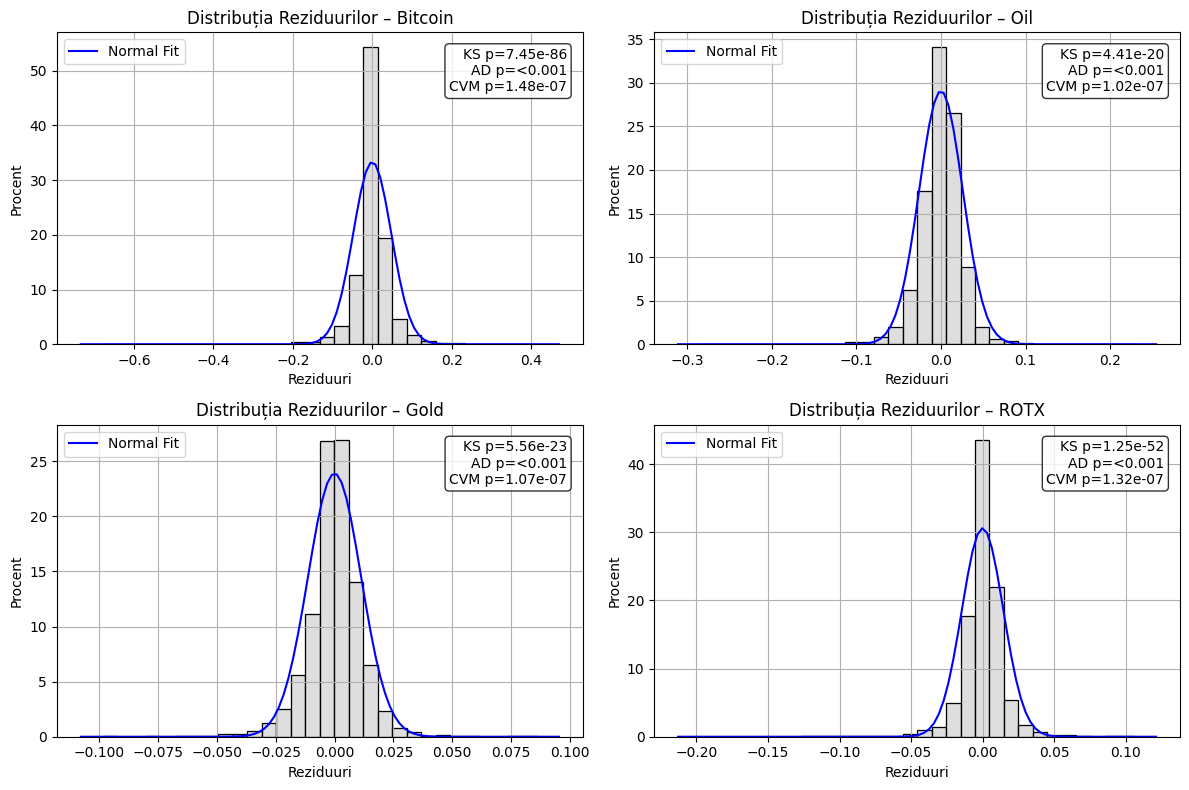

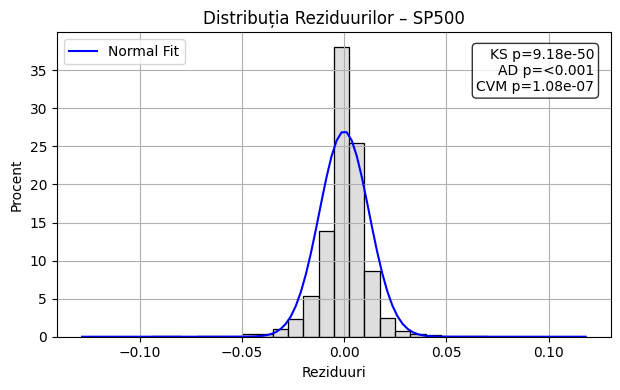

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_multiple_residuals(datasets, titles):
    """
    Plotează histograme + normal fit + p-values pe subplots.

    - datasets: listă de array-like sau pd.Series (reziduuri)
    - titles: listă de titluri (pentru fiecare grafic)
    """
    n = len(datasets)
    ncols = 2
    nrows = int(np.ceil(n / ncols))

    plt.figure(figsize=(ncols*6, nrows*4))

    for i, (data, titlu) in enumerate(zip(datasets, titles), 1):
        data = pd.Series(data).dropna()
        z = (data - np.mean(data)) / np.std(data)

        plt.subplot(nrows, ncols, i)
        sns.histplot(data, bins=30, kde=False, stat='percent', color='lightgray')
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, np.mean(data), np.std(data))
        plt.plot(x, p * 100 * (xmax - xmin) / 30, 'b-', label='Normal Fit')
        plt.title(f"Distribuția Reziduurilor – {titlu}")
        plt.xlabel("Reziduuri")
        plt.ylabel("Procent")
        plt.legend()

        # Calculează testele și p-value-urile
        ks_stat, ks_p = stats.kstest(z, 'norm')
        cvm_result = stats.cramervonmises(data, 'norm')
        ad_result = stats.anderson(data, dist='norm')

        # Anderson nu dă direct p-value, estimăm aproximativ:
        # Regulă empirică: p < 0.001 dacă A² > critical_values[-1]
        ad_p = "<0.001" if ad_result.statistic > ad_result.critical_values[-1] else ">0.001"

        # Text pe grafic
        textstr = (
            f"KS p={ks_p:.3g}\n"
            f"AD p={ad_p}\n"
            f"CVM p={cvm_result.pvalue:.3g}"
        )
        plt.gca().text(0.97, 0.95, textstr, transform=plt.gca().transAxes,
                       verticalalignment='top', horizontalalignment='right',
                       fontsize=10, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Exemplu de apel
plot_multiple_residuals(
    datasets=[r_bitcoin, r_oil, r_gold, r_rotx],
    titles=["Bitcoin", "Oil", "Gold", "ROTX"]
)

plot_multiple_residuals(
    datasets=[r_sp500],
    titles=["SP500"]
)

# **GARCH FITTING**

In [ ]:
from arch import arch_model
import pandas as pd

def compare_garch_models(series, p_range=range(1, 5), q_range=range(1, 5),
                          mean_type='Zero', show_summary=False):

    series = series.dropna()
    results = []

    vol_models = ['GARCH', 'EGARCH']
    distributions = ['normal', 't', 'skewt', 'ged']

    for vol in vol_models:
        for dist in distributions:
            if vol == 'FIGARCH':
                p_iter = [1]
                q_iter = [1]
            else:
                p_iter = p_range
                q_iter = q_range

            for p in p_iter:
                for q in q_iter:
                    try:
                        model = arch_model(series, mean=mean_type, vol=vol, p=p, q=q, dist=dist)
                        fitted = model.fit(disp='off')

                        params = fitted.params
                        pvalues = fitted.pvalues
                        total_params = len(params)
                        significant = {k: v for k, v in pvalues.items() if v < 0.05}

                        results.append({
                            'Model Volatilitate': vol,
                            'Distribuție': dist,
                            'GARCH(p,q)': f'({p},{q})',
                            'AIC': fitted.aic,
                            'BIC': fitted.bic,
                            'LogLik': fitted.loglikelihood,
                            'Nr. Parametri': total_params,
                            'Parametri Semnificativi': len(significant),
                            'Coef. Semnificativi': list(significant.keys())
                        })

                        if show_summary:
                            print(f'Model: {vol}, dist: {dist}, p: {p}, q: {q}')
                            print(fitted.summary())

                    except Exception as e:
                        print(f"Eroare {vol}({p},{q}) [{dist}]: {e}")
                        continue

    df_results = pd.DataFrame(results)

    # Sortăm modelele întâi după "parametri semnificativi = număr total"
    df_results['All_Significant'] = df_results['Parametri Semnificativi'] == df_results['Nr. Parametri']

    # Mai întâi toate cele complet semnificative, apoi restul după AIC
    df_results = df_results.sort_values(by=['All_Significant', 'AIC'], ascending=[False, True]).reset_index(drop=True)

    return df_results


In [ ]:
compare_garch_models(r_oil, show_summary=False)

,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,EGARCH,skewt,"(1,1)",-24746.714261,-24714.075574,12378.357130,5,5,"[omega, alpha[1], beta[1], eta, lambda]",True
1,EGARCH,skewt,"(2,2)",-24744.795628,-24699.101467,12379.397814,7,7,"[omega, alpha[1], alpha[2], beta[1], beta[2], ...",True
2,EGARCH,t,"(1,1)",-24705.156480,-24679.045531,12356.578240,4,4,"[omega, alpha[1], beta[1], nu]",True
3,EGARCH,t,"(2,2)",-24704.050478,-24664.884054,12358.025239,6,6,"[omega, alpha[1], alpha[2], beta[1], beta[2], nu]",True
4,GARCH,t,"(1,1)",-24703.288841,-24677.177891,12355.644420,4,4,"[omega, alpha[1], beta[1], nu]",True
...,...,...,...,...,...,...,...,...,...,...
123,EGARCH,normal,"(4,2)",-24473.576493,-24427.882331,12243.788246,7,1,[alpha[1]],False
124,GARCH,normal,"(4,3)",-24457.853350,-24405.631451,12236.926675,8,2,"[omega, alpha[1]]",False
125,GARCH,normal,"(1,4)",-24453.998687,-24414.832262,12232.999343,6,4,"[omega, alpha[1], beta[1], beta[3]]",False
126,GARCH,normal,"(3,2)",-24448.992382,-24409.825958,12230.496191,6,2,"[omega, alpha[1]]",False


In [ ]:
compare_garch_models(r_bitcoin, show_summary=False)

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,EGARCH,ged,"(2,1)",-21824.434390,-21791.435918,10917.217195,5,5,"[omega, alpha[1], alpha[2], beta[1], nu]",True
1,EGARCH,ged,"(1,2)",-21809.530959,-21776.532487,10909.765479,5,5,"[omega, alpha[1], beta[1], beta[2], nu]",True
2,EGARCH,ged,"(1,1)",-21795.794860,-21769.396082,10901.897430,4,4,"[omega, alpha[1], beta[1], nu]",True
3,GARCH,ged,"(1,2)",-21127.073316,-21094.074844,10568.536658,5,5,"[omega, alpha[1], beta[1], beta[2], nu]",True
4,EGARCH,normal,"(1,2)",-20120.320238,-20093.921460,10064.160119,4,4,"[omega, alpha[1], beta[1], beta[2]]",True
...,...,...,...,...,...,...,...,...,...,...
123,GARCH,normal,"(4,3)",-19928.170070,-19875.372514,9972.085035,8,0,[],False
124,GARCH,normal,"(3,2)",-19916.712937,-19877.114771,9964.356469,6,0,[],False
125,GARCH,normal,"(3,1)",-19901.345468,-19868.346996,9955.672734,5,3,"[omega, alpha[1], beta[1]]",False
126,GARCH,normal,"(4,2)",-19864.286190,-19818.088329,9939.143095,7,2,"[omega, alpha[1]]",False


In [ ]:
compare_garch_models(r_gold, show_summary=False)

,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,EGARCH,skewt,"(1,1)",-29985.859765,-29953.583176,14997.929882,5,5,"[omega, alpha[1], beta[1], eta, lambda]",True
1,EGARCH,t,"(1,1)",-29975.376697,-29949.555426,14991.688349,4,4,"[omega, alpha[1], beta[1], nu]",True
2,EGARCH,ged,"(1,1)",-29954.179808,-29928.358537,14981.089904,4,4,"[omega, alpha[1], beta[1], nu]",True
3,GARCH,t,"(2,2)",-29939.506146,-29900.774240,14975.753073,6,6,"[omega, alpha[1], alpha[2], beta[1], beta[2], nu]",True
4,GARCH,t,"(1,1)",-29938.340244,-29912.518972,14973.170122,4,4,"[omega, alpha[1], beta[1], nu]",True
...,...,...,...,...,...,...,...,...,...,...
123,GARCH,normal,"(4,2)",-29535.029978,-29489.842753,14774.514989,7,1,[omega],False
124,GARCH,normal,"(3,1)",-29534.280343,-29502.003754,14772.140171,5,2,"[omega, beta[1]]",False
125,GARCH,normal,"(1,3)",-29525.740199,-29493.463610,14767.870099,5,3,"[omega, alpha[1], beta[2]]",False
126,GARCH,normal,"(4,1)",-29521.469784,-29482.737878,14766.734892,6,2,"[omega, beta[1]]",False


In [ ]:
compare_garch_models(r_rotx, show_summary=False)

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,EGARCH,skewt,"(2,1)",-31416.560957,-31377.448205,15714.280478,6,6,"[omega, alpha[1], alpha[2], beta[1], eta, lambda]",True
1,EGARCH,skewt,"(1,2)",-31403.552165,-31364.439414,15707.776083,6,6,"[omega, alpha[1], beta[1], beta[2], eta, lambda]",True
2,EGARCH,t,"(2,1)",-31390.952927,-31358.358968,15700.476464,5,5,"[omega, alpha[1], alpha[2], beta[1], nu]",True
3,EGARCH,skewt,"(1,1)",-31384.081428,-31351.487469,15697.040714,5,5,"[omega, alpha[1], beta[1], eta, lambda]",True
4,GARCH,t,"(1,2)",-31382.391326,-31349.797366,15696.195663,5,5,"[omega, alpha[1], beta[1], beta[2], nu]",True
...,...,...,...,...,...,...,...,...,...,...
123,GARCH,normal,"(4,4)",-30598.042225,-30539.373098,15308.021113,9,1,[omega],False
124,GARCH,normal,"(3,1)",-30592.555551,-30559.961592,15301.277776,5,4,"[omega, alpha[1], alpha[3], beta[1]]",False
125,GARCH,normal,"(4,3)",-30582.607373,-30530.457037,15299.303686,8,1,[omega],False
126,GARCH,normal,"(4,2)",-30557.625212,-30511.993669,15285.812606,7,2,"[omega, alpha[1]]",False


In [ ]:
compare_garch_models(r_sp500, show_summary=False)

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Model Volatilitate,Distribuție,"GARCH(p,q)",AIC,BIC,LogLik,Nr. Parametri,Parametri Semnificativi,Coef. Semnificativi,All_Significant
0,EGARCH,skewt,"(2,1)",-33670.567936,-33631.335382,16841.283968,6,6,"[omega, alpha[1], alpha[2], beta[1], eta, lambda]",True
1,EGARCH,skewt,"(1,1)",-33663.130304,-33630.436509,16836.565152,5,5,"[omega, alpha[1], beta[1], eta, lambda]",True
2,GARCH,t,"(3,1)",-33594.088951,-33554.856397,16803.044476,6,6,"[omega, alpha[1], alpha[2], alpha[3], beta[1],...",True
3,GARCH,t,"(2,1)",-33588.025300,-33555.331505,16799.012650,5,5,"[omega, alpha[1], alpha[2], beta[1], nu]",True
4,GARCH,t,"(4,1)",-33587.954127,-33542.182814,16800.977064,7,7,"[omega, alpha[1], alpha[2], alpha[3], alpha[4]...",True
...,...,...,...,...,...,...,...,...,...,...
123,EGARCH,normal,"(1,3)",-33273.272489,-33240.578694,16641.636245,5,3,"[omega, alpha[1], beta[1]]",False
124,EGARCH,normal,"(1,4)",-33271.272490,-33232.039936,16641.636245,6,0,[],False
125,EGARCH,normal,"(3,4)",-33268.123630,-33215.813558,16642.061815,8,3,"[omega, alpha[1], beta[3]]",False
126,GARCH,normal,"(3,4)",-33266.995192,-33214.685120,16641.497596,8,1,[omega],False


# **FIT MODELE GARCH**

In [ ]:

best_garch_oil = arch_model(r_oil, mean='Zero', vol='EGARCH', p=1, q=1, dist='skewt')
fitted_garch_oil = best_garch_oil.fit(disp='off')
print("\n--- Best GARCH model for Oil ---")
print(fitted_garch_oil.summary())

best_garch_bitcoin = arch_model(r_bitcoin, mean='Zero', vol='EGARCH', p=2, q=1, dist='ged')
fitted_garch_bitcoin = best_garch_bitcoin.fit(disp='off')
print("\n--- Best GARCH model for Bitcoin ---")
print(fitted_garch_bitcoin.summary())

best_garch_gold = arch_model(r_gold, mean='Zero', vol='EGARCH', p=1, q=1, dist='skewt')
fitted_garch_gold = best_garch_gold.fit(disp='off')
print("\n--- Best GARCH model for Gold ---")
print(fitted_garch_gold.summary())

best_garch_rotx = arch_model(r_rotx, mean='Zero', vol='EGARCH', p=2, q=1, dist='skewt')
fitted_garch_rotx = best_garch_rotx.fit(disp='off')
print("\n--- Best GARCH model for ROTX ---")
print(fitted_garch_rotx.summary())

best_garch_sp500 = arch_model(r_sp500, mean='Zero', vol='EGARCH', p=2, q=1, dist='skewt')
fitted_garch_sp500 = best_garch_sp500.fit(disp='off')
print("\n--- Best GARCH model for S&P 500 ---")
print(fitted_garch_sp500.summary())


--- Best GARCH model for Oil ---
                             Zero Mean - EGARCH Model Results                            
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:                12378.4
Distribution:      Standardized Skew Student's t   AIC:                          -24746.7
Method:                       Maximum Likelihood   BIC:                          -24714.1
                                                   No. Observations:                 5053
Date:                           Sun, Jun 15 2025   Df Residuals:                     5053
Time:                                   16:00:22   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
----

# **ROLLING PREDICTIONS**

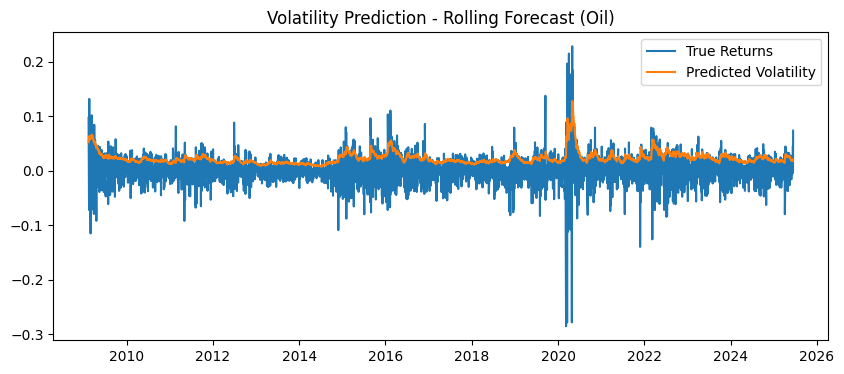

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import warnings

warnings.filterwarnings("ignore")

# ROLLING WINDOW LOGIC
window_size = 1000
rolling_predictions_oil = []

for i in range(window_size, len(r_oil)):
    warnings.filterwarnings("ignore")
    train = r_oil[i-window_size:i]
    model = arch_model(train, mean='Zero', vol='EGARCH', p=1, q=1, dist='skewt')
    try:
        model_fit = model.fit(disp='off', options={'maxiter': 500})
        pred = model_fit.forecast(horizon=1)
        forecast_vol = np.sqrt(pred.variance.values[-1, :][0])
        if forecast_vol > 100:
            forecast_vol = np.nan
        rolling_predictions_oil.append(forecast_vol)
    except:
        rolling_predictions_oil.append(np.nan)

rolling_predictions_oil = pd.Series(rolling_predictions_oil, index=r_oil.index[window_size:])

plt.figure(figsize=(10,4))
plt.plot(r_oil[-len(rolling_predictions_oil):], label='True Returns')
plt.plot(rolling_predictions_oil, label='Predicted Volatility')
plt.title('Volatility Prediction - Rolling Forecast (Oil)')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: Con

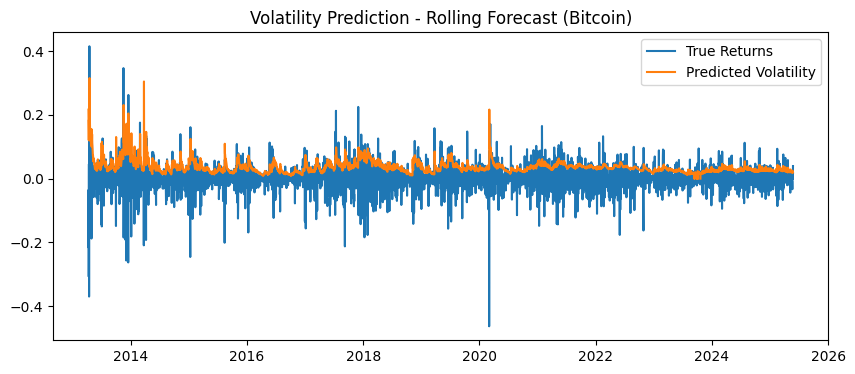

In [ ]:
##########################
# BITCOIN: EGARCH(2,1), ged
##########################

window_size = 1000  # păstrăm rolling window consistent
rolling_predictions_bitcoin = []

for i in range(window_size, len(r_bitcoin)):
    train = r_bitcoin[i-window_size:i]
    model = arch_model(train, mean='Zero', vol='EGARCH', p=2, q=1, dist='ged')
    try:
        model_fit = model.fit(disp='off', options={'maxiter': 500})
        pred = model_fit.forecast(horizon=1)
        forecast_vol = np.sqrt(pred.variance.values[-1, :][0])

        # filtrare mai strictă pentru Bitcoin
        if forecast_vol > 10:  # 100 era mult prea permisiv
            forecast_vol = np.nan

        rolling_predictions_bitcoin.append(forecast_vol)
    except:
        rolling_predictions_bitcoin.append(np.nan)

rolling_predictions_bitcoin = pd.Series(rolling_predictions_bitcoin, index=r_bitcoin.index[window_size:])

plt.figure(figsize=(10,4))
plt.plot(r_bitcoin[-len(rolling_predictions_bitcoin):], label='True Returns')
plt.plot(rolling_predictions_bitcoin, label='Predicted Volatility')
plt.title('Volatility Prediction - Rolling Forecast (Bitcoin)')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/uni

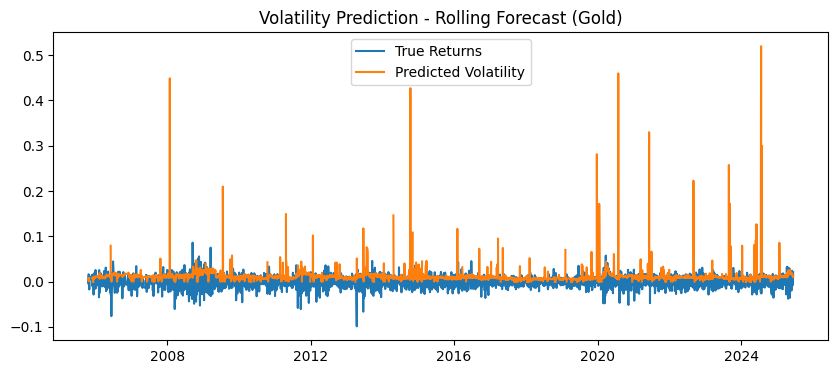

In [ ]:
window_size = 100
rolling_predictions_gold = []

for i in range(window_size, len(r_gold)):
    train = r_gold[i-window_size:i]
    model = arch_model(train, mean='Zero', vol='EGARCH', p=1, q=1, dist='skewt')
    try:
        model_fit = model.fit(disp='off', options={'maxiter': 500})
        pred = model_fit.forecast(horizon=1)
        forecast_vol = np.sqrt(pred.variance.values[-1, :][0])

        if forecast_vol > 1:   # prag adaptat pentru aur
            forecast_vol = np.nan

        rolling_predictions_gold.append(forecast_vol)
    except:
        rolling_predictions_gold.append(np.nan)

rolling_predictions_gold = pd.Series(rolling_predictions_gold, index=r_gold.index[window_size:])

plt.figure(figsize=(10,4))
plt.plot(r_gold[-len(rolling_predictions_gold):], label='True Returns')
plt.plot(rolling_predictions_gold, label='Predicted Volatility')
plt.title('Volatility Prediction - Rolling Forecast (Gold)')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarn

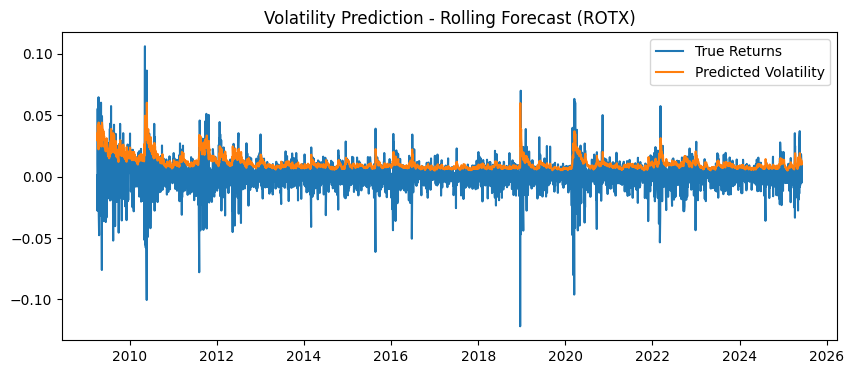

In [ ]:
##########################
# ROTX: EGARCH(2,1), skewt
##########################

rolling_predictions_rotx = []

for i in range(window_size, len(r_rotx)):
    warnings.filterwarnings("ignore")
    train = r_rotx[i-window_size:i]
    model = arch_model(train, mean='Zero', vol='EGARCH', p=2, q=1, dist='skewt')
    try:
        model_fit = model.fit(disp='off', options={'maxiter': 500})
        pred = model_fit.forecast(horizon=1)
        forecast_vol = np.sqrt(pred.variance.values[-1, :][0])
        if forecast_vol > 100:
            forecast_vol = np.nan
        rolling_predictions_rotx.append(forecast_vol)
    except:
        rolling_predictions_rotx.append(np.nan)

rolling_predictions_rotx = pd.Series(rolling_predictions_rotx, index=r_rotx.index[window_size:])

plt.figure(figsize=(10,4))
plt.plot(r_rotx[-len(rolling_predictions_rotx):], label='True Returns')
plt.plot(rolling_predictions_rotx, label='Predicted Volatility')
plt.title('Volatility Prediction - Rolling Forecast (ROTX)')
plt.legend()
plt.show()

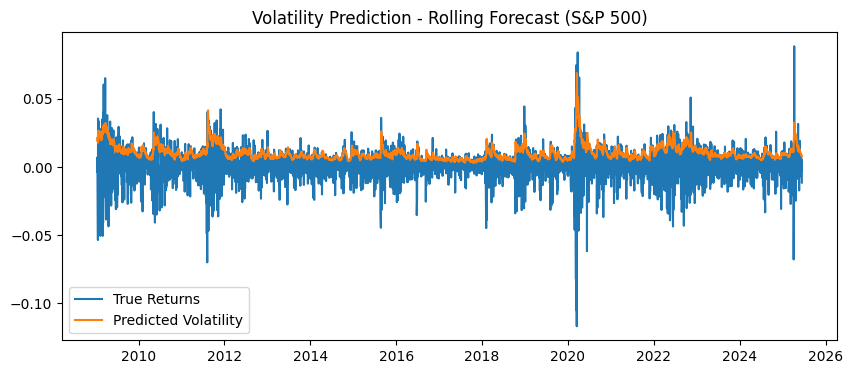

In [ ]:
##########################
# S&P 500: EGARCH(2,1), skewt
##########################

rolling_predictions_sp500 = []

for i in range(window_size, len(r_sp500)):
    warnings.filterwarnings("ignore")
    train = r_sp500[i-window_size:i]
    model = arch_model(train, mean='Zero', vol='EGARCH', p=2, q=1, dist='skewt')
    try:
        model_fit = model.fit(disp='off', options={'maxiter': 500})
        pred = model_fit.forecast(horizon=1)
        forecast_vol = np.sqrt(pred.variance.values[-1, :][0])
        if forecast_vol > 100:
            forecast_vol = np.nan
        rolling_predictions_sp500.append(forecast_vol)
    except:
        rolling_predictions_sp500.append(np.nan)

rolling_predictions_sp500 = pd.Series(rolling_predictions_sp500, index=r_sp500.index[window_size:])

plt.figure(figsize=(10,4))
plt.plot(r_sp500[-len(rolling_predictions_sp500):], label='True Returns')
plt.plot(rolling_predictions_sp500, label='Predicted Volatility')
plt.title('Volatility Prediction - Rolling Forecast (S&P 500)')
plt.legend()
plt.show()

# **ROLLING VAR**

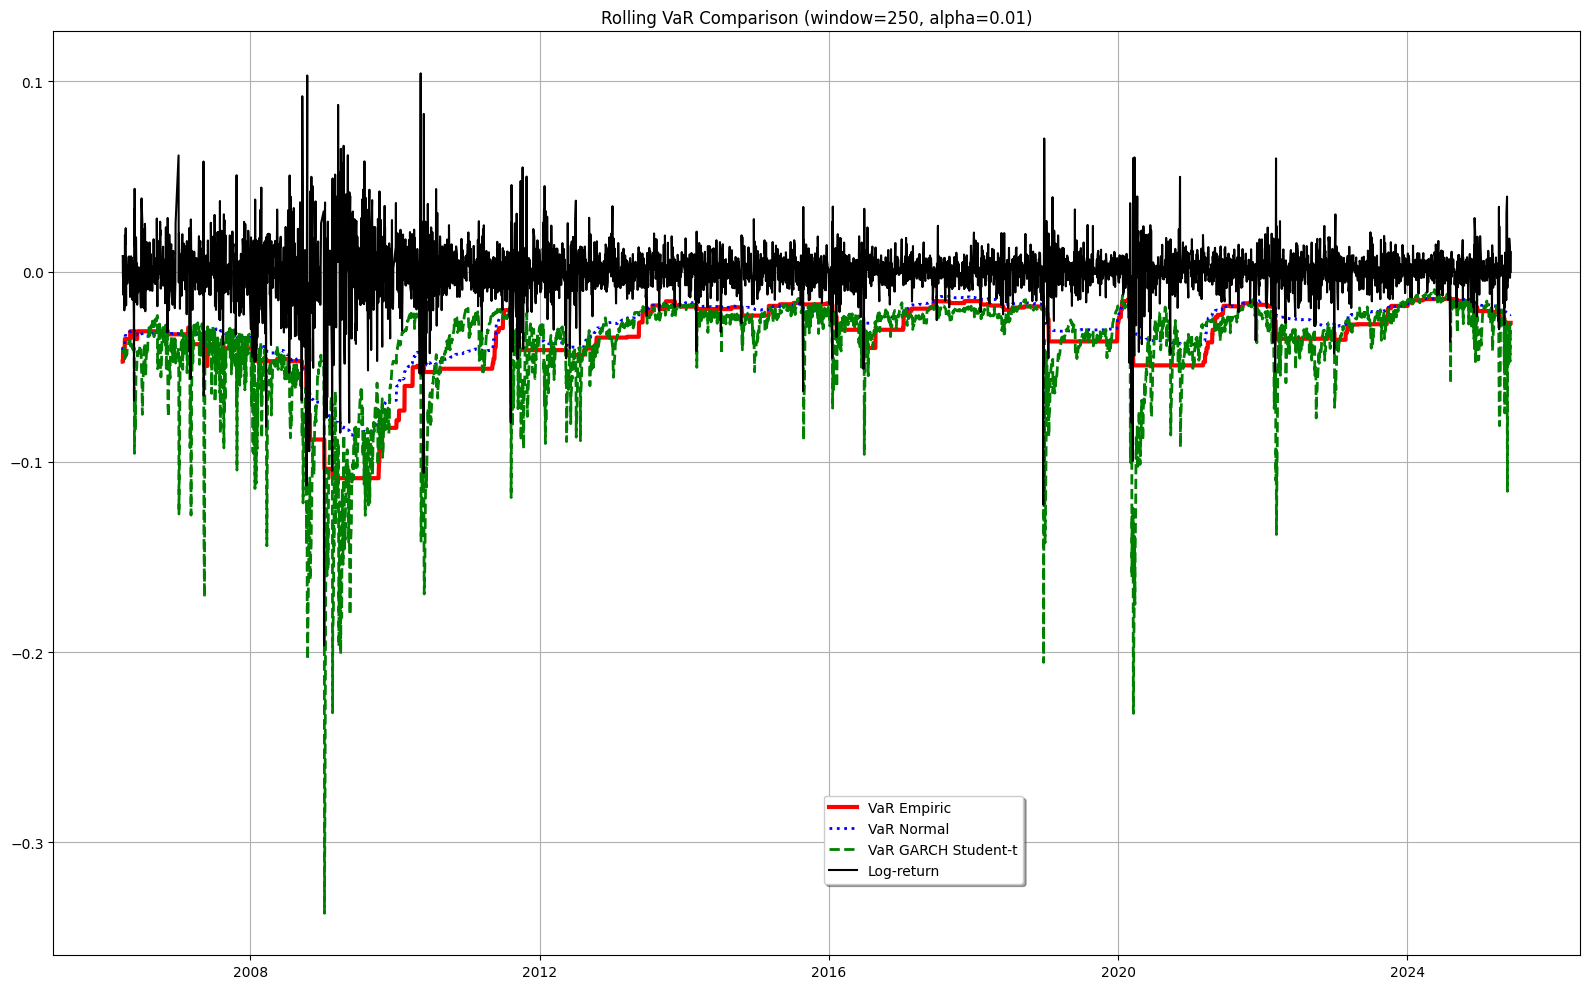

,VaR_empiric,VaR_normal,VaR_t,VaR_GARCH_n,VaR_GARCH_t,Actual_Return
Date,,,,,,
2006-03-27,-0.047278,-0.041196,-0.068632,[-0.03148106473431331],[-0.041947711118565455],0.008235
2006-03-28,-0.047278,-0.040910,-0.068920,[-0.031362061779791665],[-0.04186607849895133],-0.002787
2006-03-29,-0.040388,-0.039155,-0.062653,[-0.03091597054292788],[-0.042121365243533125],-0.003619
2006-03-30,-0.040388,-0.038801,-0.062506,[-0.030786379814352883],[-0.042223557209979855],-0.012140
2006-03-31,-0.040388,-0.038647,-0.062933,[-0.030731843800517758],[-0.04197810272149053],-0.003863
...,...,...,...,...,...,...
2025-06-02,-0.026892,-0.022505,-0.045527,[-0.01793694436034352],[-0.02663927823042718],0.012373
2025-06-03,-0.026892,-0.022539,-0.045831,[-0.03124697564764084],[-0.04722098421294526],-0.003207
2025-06-04,-0.026892,-0.022568,-0.045462,[-0.02807709893451546],[-0.04181947106297784],0.003933


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from arch import arch_model
import warnings

warnings.filterwarnings("ignore")

def compute_rolling_var_garch(log_returns, window=250, alpha=0.01):
    """
    Estimează Value at Risk (VaR) folosind mai multe metode, inclusiv GARCH.

    Parametri:
    - log_returns: Series sau array cu log-returnuri (1D)
    - window: dimensiunea ferestrei rulante (ex: 250)
    - alpha: nivelul de semnificație (ex: 0.01)

    Returnează:
    - DataFrame cu VaR-uri și log-returnurile reale
    """

    if isinstance(log_returns, (pd.DataFrame, pd.Series)):
        log_returns = log_returns.squeeze()
    log_returns = pd.Series(log_returns).dropna().replace([np.inf, -np.inf], np.nan).dropna()
    log_returns_values = log_returns.to_numpy()

    VaR_empiric, VaR_normal, VaR_t = [], [], []
    VaR_GARCH_n, VaR_GARCH_t = [], []

    iterations = len(log_returns_values) - window

    for i in range(1, iterations):
        ret = log_returns_values[i:(window + i - 1)]
        if len(ret) < 10:
            continue  # sărim ferestre prea scurte

        mu, sigma = ret.mean(), ret.std()

        # VaR normal
        v_normal = norm.ppf(alpha) * sigma + mu
        VaR_normal.append(v_normal)

        # VaR Student-t
        nu = t.fit(ret)[0]
        v_t = t.ppf(alpha, nu) * sigma + mu
        VaR_t.append(v_t)

        # VaR empiric
        v_empiric = np.quantile(ret, alpha)
        VaR_empiric.append(v_empiric)

        # VaR GARCH normal
        model_norm = arch_model(ret * 100, vol='GARCH', p=1, q=1)
        fit_norm = model_norm.fit(disp=0)
        yhat = fit_norm.forecast(horizon=1)
        var_n = 0.01 * np.sqrt(yhat.variance.values[-1]) * norm.ppf(alpha) + mu
        VaR_GARCH_n.append(var_n)

        # VaR GARCH Student-t
        model_t = arch_model(ret * 100, vol='GARCH', p=1, q=1, dist='StudentsT')
        fit_t = model_t.fit(disp=0)
        df_t = fit_t.params['nu']
        yhat = fit_t.forecast(horizon=1)
        var_t = 0.01 * np.sqrt(yhat.variance.values[-1]) * t.ppf(alpha, df_t) + mu
        VaR_GARCH_t.append(var_t)

    # Pregătim rezultatele
    actual_returns = log_returns_values[(window + 1):(window + 1 + len(VaR_empiric))]
    dates = log_returns.index[(window + 1):(window + 1 + len(VaR_empiric))]

    # Afișare grafic
    plt.figure(figsize=(16, 10))
    plt.plot(dates, VaR_empiric, label='VaR Empiric', c='red', linewidth=3)
    plt.plot(dates, VaR_normal, label='VaR Normal', c='blue', linestyle='dotted', linewidth=2)
    plt.plot(dates, VaR_GARCH_t, label='VaR GARCH Student-t', c='green', linestyle='dashed', linewidth=2)
    plt.plot(dates, VaR_GARCH_n, label='VaR GARCH Normal', c='green', linewidth=2)
    plt.plot(dates, actual_returns, label='Log-return', c='black')
    plt.legend(loc='lower left', bbox_to_anchor=(0.5, 0.07), fancybox=True, shadow=True)
    plt.title(f"Rolling VaR Comparison (window={window}, alpha={alpha})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Returnăm într-un DataFrame
    return pd.DataFrame({
        'VaR_empiric': VaR_empiric,
        'VaR_normal': VaR_normal,
        'VaR_t': VaR_t,
        'VaR_GARCH_n': VaR_GARCH_n,
        'VaR_GARCH_t': VaR_GARCH_t,
        'Actual_Return': actual_returns
    }, index=dates)

compute_rolling_var_garch(rotx_log_returns['Close'])